# Análisis de la corrupción en México

#### ¿Por qué analizar la corrupción?
Se considera a la corrupción como uno de los más relevantes obstáculos para el desarrollo del país, y como tal, es necesario entenderlo para saber afrontarlo de manera efectiva, y con esto, ayudar a construir una sociedad más justa y menos desigual.

## Generación del dataset del CPI
**Nota**: El código de esta sección se desarrolló originalmente como un proyecto por separado, por lo tanto, tambien es posible encontrarlo documentado en el siguiente repositorio:

<p align="center">
  
  <div align="center"><a href="https://github.com/Erick-INCS/Bedu-py" page="_blank"><img src="https://github.com/Erick-INCS/Bedu-py/blob/main/img/preprocessing.png?raw=true">
  <br>
  Entra aquí</a>
</div>

</p>


<img src="https://cdn3.iconfinder.com/data/icons/basicolor-signs-warnings/24/182_warning_notice_error-256.png" width="60px"/>

**Advertencia**: Esta sección de código (Generación del dataset del CPI) puede llegar a durar hasta 3 horas en una computadora tradicional, por lo tanto, no es necesario ejecutar este apartado ya que los datasets resultantes de esta sección se cargan desde el repositorio de Github mas adelante.

El siguiente diagrama explica el siguiente procesos en términos generales:

<p align="center">
<img src="https://github.com/Erick-INCS/Bedu-py/blob/main/img/diagrama.png?raw=true"/>
</p>

**Web Scraping**

Descargar los 305 reportes del CPI.

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from os.path import exists
from os import makedirs

URL = 'https://onuhabitat.org.mx/index.php/' +\
      'indice-de-las-ciudades-prosperas-cpi-mexico-2018'

HEADERS = {
    'accept': 'text/html,application/xhtml+xml,application/xml;' +
              'q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,' +
              'application/signed-exchange;v=b3;q=0.9',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36' +
                  ' (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36}'
}


def get_urls(base_url):
    """ Obtener todos los URLs de los archivos PDF """
    res = requests.get(base_url, headers=HEADERS)
    res = BeautifulSoup(res.text, 'html.parser')
    res = res.find_all(href=re.compile('pdf'))
    return res


def download_files(links, directory=''):
    """ Descargar los archivos """
    links = list(map(
        lambda lk: lk.attrs['href'],
        links))

    def download_and_save(url):
        print('\nDownloading:', url)
        req = requests.get(url, verify=False)
        with open(directory + '_'.join(url.split('/')[-2:]), 'wb') as pdf:
            pdf.write(req.content)

    list(map(
        download_and_save,
        links))


directory = 'pdfs/'
if not exists(directory):
  makedirs(directory)

content = get_urls(URL)
download_files(content, directory)

print('Done.')

**PDF Mining**

Buscar e interpretar las tablas a partir de la lectura de los PFDs como texto.

In [ ]:
# Instalar dependencias
!apt-get install -y libpoppler-cpp-dev && pip install wheel pdfminer.six pdftotext termcolor

In [ ]:
#!/usr/bin/env python3
""" Extraer una tabla de un PDF """

import re
import pdftotext
import pandas as pd
from io import StringIO
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from termcolor import colored
from os.path import exists
from os import makedirs

RE_EX = r'(tabla).*\d.*Síntesis de resultados por dimensión y subdimensión'


def extract_table(path):
    """ Buscar las paginas de la tabla en el archivo PDF """
    re_ex = RE_EX
    pages = []
    page_num = 1
    with open(path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        for page in PDFPage.create_pages(doc):
            rsrcmgr = PDFResourceManager()
            output_string = StringIO()
            device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
            interpreter = PDFPageInterpreter(rsrcmgr, device)
            interpreter.process_page(page)
            finder = re.search(re_ex, output_string.getvalue(), re.IGNORECASE)
            print('Searching table', '\tCurrent page:', page_num)
            if finder:
                print('Table finded.')
                pages.append(page_num)

            page_num += 1
            if pages and page_num - pages[-1] > 1:
                print('-> Searching break.')
                break

    print('\nGenerating table in', pages)
    table = extract_text(path, pages)
    table = isolate(table)
    table = add_separations(table)

    return table


def extract_text(path, pages):
    """ Extraer el texto 'crudo' de el PDF """
    out = []
    with open(path, 'rb') as file:
        pdftotext_string = pdftotext.PDF(file)

    for i in pages:
        out.append(pdftotext_string[i - 1])

    return out


def isolate(pages):
    """ Eliminar contenido irrelevante (acotar texto) """

    cut_regex = [
        r' *Consolidar políticas *Fortalecer políticas *Priorizar políticas.*',
        r' *urbanas +urbanas +urbanas.*']
    filter_regex = [
            re.compile(r'^ *\w+ *$')]

    c_ix = 0
    while c_ix < len(pages):
        pages[c_ix] = pages[c_ix].splitlines()
        for ln_ix, line in enumerate(pages[c_ix]):
            if re.search(RE_EX, line, re.IGNORECASE):
                pages[c_ix] = pages[c_ix][ln_ix+1:]
                break

        for rgex in cut_regex:
            for ln_ix, line in enumerate(pages[c_ix]):
                if re.search(rgex, line, re.IGNORECASE):
                    pages[c_ix] = pages[c_ix][:ln_ix]
                    break

        pages[c_ix] = list(filter(
            lambda line: sum([
                rg.match(line) is not None for rg in filter_regex]) == 0,
            pages[c_ix]))

        pages[c_ix] = '\n'.join(pages[c_ix])
        c_ix += 1

    return pages


def squeeze(a_list):
    """ Reducir la dimensionalidad """
    length = len(a_list)
    while length >= 0:
        current = a_list.pop(0)
        if isinstance(current, list):
            a_list.extend(current)
        else:
            a_list.append(current)
        length -= 1
    return a_list

def add_separations(pages, space_tolerance=3):
    """ Separar el texto por columnas """
    for p_ix, page in enumerate(pages):
        page = re.sub(' {3,}', '|', page)

        page_lines = pages[p_ix].splitlines()
        page_sep_ixs = page.splitlines()
        page_sep_ixs = list(map(
            lambda ix_ln: list(map(
                page_lines[ix_ln[0]].index,
                filter(lambda e: e, ix_ln[1].split('|')))),
            enumerate(page_sep_ixs)))
        squeeze(page_sep_ixs)

        tb_cols = {}
        for num in set(page_sep_ixs):
            added = False

            for key in tb_cols:
                if (tb_cols[key]['min'] - space_tolerance <= num) and\
                   (tb_cols[key]['max'] + space_tolerance >= num):

                    tb_cols[key]['min'] = min(num, tb_cols[key]['min'])
                    tb_cols[key]['max'] = max(num, tb_cols[key]['max'])
                    added = True
            if not added:
                tb_cols[len(tb_cols.keys())] = {
                        'max': num,
                        'min': num}

        # Merge lines
        to_pop = []
        for key in tb_cols:
            if key in to_pop:
                continue

            other_keys = list(tb_cols.keys()).copy()
            other_keys.remove(key)
            for o_key in other_keys:
                if not ((tb_cols[key]['min'] - space_tolerance > tb_cols[o_key]['max']) or
                        (tb_cols[key]['max'] + space_tolerance < tb_cols[o_key]['min'])):
                    tb_cols[key]['min'] = min(
                            tb_cols[key]['min'],
                            tb_cols[o_key]['min'])

                    tb_cols[key]['max'] = max(
                        tb_cols[key]['max'],
                        tb_cols[o_key]['max'])

                    to_pop.append(o_key)

        for poop in to_pop:
            tb_cols.pop(poop)

        print('Columns: ', tb_cols, '\n\n')

        tb_cols = list(map(lambda e: e['min'], tb_cols.values()))
        tb_cols.sort()

        line_length = max(map(len, page_lines))

        pages[p_ix] = pd.DataFrame(map(
            lambda ln: [ln[tb_cols[pk[0]]:pk[1]]
                        for pk in enumerate(tb_cols[1:] + [line_length])],
            page_lines))

    return pages


def save_datasets(ds, pdf_name, directory=''):
    """ Guardar el dataset como CSV """
    if not exists(directory):
      makedirs(directory)
    
    print(f'{directory}{pdf_name.split("/")[-1].replace(".pdf", "")}_0..{len(ds)}.csv')
    list(map(
        lambda tb: tb[1].to_csv(
            f'{directory}{pdf_name.split("/")[-1].replace(".pdf", "")}_{tb[0]}.csv',
            index=False),
        enumerate(ds)))


def extract_and_save(file_path, out_dir=''):
    """ Extraer una tabla de un PDF y guardar el dataset resultante """
    save_datasets(
            extract_table(file_path),
            file_path,
            out_dir)


In [ ]:
#!/usr/bin/env python3
""" Extraer todas las tablas de los archivos PDF existentes """

from os import listdir
import pandas as pd

PDF_DIR = 'pdfs/'
DATA_DIR = 'data/'


def extract_all(pdfs_dir, data_dir):
    """ Extraer todas las tablas """
    files = pd.Series(listdir(pdfs_dir))
    (pdfs_dir + files).apply(extract_and_save, args=[data_dir])


# Start!
extract_all(PDF_DIR, DATA_DIR)

**Preprocesamiento**

Leer datasets, arreglar inconsistencias, formatos, etc.

In [ ]:
#!/usr/bin/env python3
""" Arreglar el formato de los DataFrames """

from os import listdir
from collections import Counter
import re
from functools import reduce
from math import isnan
import pandas as pd


def read_datasets(d_dir):
    """ Retorna una lista agrupada de los datasets disponibles """
    files = d_dir + pd.Series(listdir(d_dir))
    files = Counter(files.map(lambda fn: fn[:-6]))
    names = list(map(lambda s: ' '.join(s.split('_')[2:]), files.keys()))
    claves = list(map(
        lambda s: s.split('/')[-1].split('_')[1], files.keys()))
    periodos = list(map(
        lambda s: s.split('/')[-1].split('_')[0], files.keys()))

    files = pd.Series([
        [f'{fn}_{i}.csv' for i in range(files[fn])] for fn in files])

    return (files.map(
            lambda fl: [pd.read_csv(name, dtype=str) for name in fl]),
           names, claves, periodos)


def check_num_format(str_num):
    """ Verifica si un numero esta completo segun su formato """
    return (isinstance(str_num, float) and (not isnan(str_num))) or\
           (re.compile(r' *\d+\.\d{2} *').match(str(str_num)) is not None) or\
           (str(str_num).strip() in ('', '-'))


def is_part_num(str_num):
    """ Verifica si una cade es un numero parcial (o cortado) """
    return re.compile(r' *[\.|\d]+ *').match(str_num) is not None


def is_invalid_col(dataset, col):
    """ Retorna si la columna dada es valida """
    return dataset[col].apply(check_num_format).sum() == 0


def join_datasets(ds_list, name='', index=-1, clave='', periodo=''):
    """ Une multiples dataframes del mismo estado """
    # First cut
    first = ds_list[0]
    first['0'] = first['0'].str.strip()

    if not name:
        name = first[:first[first['0'] == 'ID'].index[0]]

    first = first[first[first['0'] == 'ID'].index[0]+1:]
    ds_list[0] = first

    for ix_ds, dataset in enumerate(ds_list):

        # Titulo de la categoria
        dataset['1'] = dataset['1'] + dataset['2']
        dataset = dataset.drop(['2'], axis=1)
        dataset['1'] = dataset['1'].str.strip()

        # Eliminar columna del grupo
        assert len(dataset['0'].unique()) in (3, 5), \
               f'Error de formato en {name}!'

        dataset = dataset.drop(['0'], axis=1)

        # Formato de los numeros
        rem_cols = list(dataset.columns)[1:]
        for col in rem_cols:

            dataset[col] = dataset[col].fillna('')

            # Combina columnas cortadas
            col_index = list(dataset.columns).index(col)
            if (dataset[col].apply(check_num_format).sum() not in
                    (0, dataset.shape[0])) and\
               (col_index > 1) and\
               ((dataset[col].astype(str).apply(is_part_num).sum() > 0) or
                   (dataset[col].isna().sum() > dataset.shape[0]/2)):

                l_invalid = is_invalid_col(
                        dataset,
                        dataset.columns[col_index-1])

                r_invalid = None
                if col_index + 1 == len(dataset.columns):
                    r_invalid = True
                else:
                    r_invalid = is_invalid_col(
                            dataset,
                            dataset.columns[col_index + 1])

                if not r_invalid and not l_invalid:
                    r_invalid = (dataset[col][
                        dataset[col].astype(str).apply(is_part_num)
                        ].astype(str).str[-1] == ' ').sum()

                    l_invalid = (dataset[col][
                        dataset[col].astype(str).apply(is_part_num)
                        ].astype(str).str[0] == ' ').sum()

                if r_invalid != l_invalid:
                    if r_invalid:
                        dataset[dataset.columns[col_index - 1]] = \
                            dataset[dataset.columns[col_index - 1]].\
                            fillna('').astype(str).str.replace('-', '') + \
                            dataset[col].astype(str).replace('NaN', '').\
                            fillna('')
                        dataset[dataset.columns[col_index - 1]] =\
                            pd.to_numeric(
                                    dataset[dataset.columns[col_index - 1]],
                                    errors='coerce')
                        dataset = dataset.drop([col], axis=1)
                    else:
                        dataset[dataset.columns[col_index + 1]] =\
                            dataset[col].astype(str).str.\
                            replace('-', '').replace('NaN', '').\
                            fillna('') +\
                            dataset[dataset.columns[col_index + 1]].\
                            astype(str).str.replace('-', '').\
                            replace('NaN', '').fillna('')
                        dataset = dataset.drop([col], axis=1)
                    continue

            dataset[col] = dataset[col].astype(str).str.strip()
            dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

        dataset = dataset.dropna(how='all', axis=1)
        dataset = dataset.dropna(how='all', axis=0)

        assert len(dataset.columns) in (2, 3),\
               f'Bad columns for {name}, i:{index}.'

        ds_list[ix_ds] = dataset

    assert len(ds_list) == 2, f'Unexpected, more than 2 datasets in {name}'

    assert len(set(map(
        lambda ls: len(ls.columns),
        ds_list))) == 1, f'Different number of columns in {name}, i: {index}'

    c_names = ['desc', 'municipio']
    if len(ds_list[0].columns) == 3:
        c_names = c_names + ['aglomeracion_urbana']

    ds_list = list(map(
        lambda ds: ds.rename(columns={
            pnm[1]: c_names[pnm[0]] for pnm in enumerate(ds.columns)}),
        ds_list))

    ds_list = reduce(
        lambda ds1, ds2: ds1.append(ds2),
        ds_list).reset_index().drop(['index'], axis=1)

    ds_list['estado'] = name
    ds_list['clave'] = clave
    ds_list['periodo'] = periodo
    return ds_list


# Ejecutar la magia aqui ...
datasets, ds_names, ds_claves, ds_periodos = read_datasets('data/')

the_dataset = reduce(
        lambda dsa, dsb: dsa.append(dsb),
        list(map(
            lambda zp: join_datasets(*zp),
            zip(datasets, ds_names, range(len(ds_names)), ds_claves,
                ds_periodos))
              )
)

the_dataset = the_dataset.reset_index()
the_dataset = the_dataset.drop(['index'], axis=1)
the_dataset.to_csv('CPI_Mex.csv', index=False)
print('Dataset', the_dataset, 'saved')

**Generar el dataset final**

Combinar todos los datasets de los estados en uno solo, donde la cada rubro (valores de la columna _desc_) sea una columna en lugar de un registro con una combinación única de _nombre de estado_ y _descripcion_.

In [ ]:
#!/usr/bin/env python3
""" Extraer los nombres de los estados de los PDFs """

import re
import pdftotext
import pandas as pd
from os import listdir

def extract_text_sp(path, page):
    """ Extraer el texto de una pagina del PDF """
    out = []
    with open(path, 'rb') as file:
        pdftotext_string = pdftotext.PDF(file)
        out.append(pdftotext_string[page])
    return out

def extract_name(path):
    """ Obtener el nombre el estado y nunicipio a partir del PDF como texto """
    table = extract_text_sp(path, 2)[0]
    rg_name = re.compile(r' *([\w| ]+), *M.{1}xico')

    res = rg_name.search(table)

    if res:
        spl_name = path.split('/')[-1].replace('pdf', '').split('_')
        return (res.groups()[0],
                spl_name[1],
                ' '.join(spl_name[2:]),
                spl_name[0])
    return None


# Ejecutar la extraccion
pdfs_path = 'pdfs/'
pdfs = pdfs_path + pd.Series(listdir(pdfs_path))

df = pd.DataFrame(
    pdfs.map(extract_name).to_list(),
    columns=['estado', 'clave', 'municipio', 'periodo'])

df.to_csv('Names.csv', index=False)
print(df, 'saved')

In [ ]:
#!/usr/bin/env python3
""" Agrupar por estado """

import pandas as pd

ds = pd.read_csv('./CPI_Mex.csv')
estados = pd.read_csv('Names.csv')

ds = ds.join(estados[['clave', 'estado']].set_index('clave'), on='clave')
ds = pd.pivot(
        ds,
        index=['estado', 'municipio'],
        columns='desc',
        values='calificacion')

ds = ds.reset_index()
ds.to_csv('CPI_Mex_full.csv', index=False)

<img src="https://cdn3.iconfinder.com/data/icons/basicolor-signs-warnings/24/182_warning_notice_error-256.png" width="60px"/>

**Aquí termina el peligro**: Pase usted con toda confianza a ejecutar el código a partir de aquí. 

:D

## Importacion de las librerias necesarias para el proyecto

In [ ]:
import pandas as pd
import numpy as np
import re
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar los datasets

In [ ]:
# Cargamos los archivos csv que contienen la informacion
ds = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Bedu-py/main/asf_2017-2019.csv',
     encoding='latin-1') #dataset de corrupcion

ds_cpi = pd.read_csv('https://raw.githubusercontent.com/Erick-INCS/Bedu-py/main/CPI_Mex_full.csv') #dataset de indice de corrupcion
ds.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1


In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32404 entries, 0 to 32403
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Año Cuenta Pública                32404 non-null  int64 
 1   Grupo Funcional                   32404 non-null  object
 2   Sector                            32404 non-null  object
 3   Ente Fiscalizado                  32404 non-null  object
 4   Entidad Federativa                32404 non-null  object
 5   Tipo Auditoría                    32404 non-null  object
 6   Número                            32404 non-null  int64 
 7   Título                            32404 non-null  object
 8   Universo (miles pesos)            32404 non-null  object
 9   Muestra (miles pesos)             32404 non-null  object
 10  Ente a quien se dirige la Acción  32404 non-null  object
 11  Tipo Acción                       32404 non-null  object
 12  Clave Acción      

# Limpieza de dataset de corrupción

In [ ]:
# Buscamos que Tipos de Accion se tomaron en cada una de las auditorias en busqueda de aquellos que puedan dar indicios de corrupcion
ds['Tipo Acción'].unique()

array(['Pliego de Observaciones',
       'Promoción de Responsabilidad Administrativa Sancionatoria', '-',
       'Recomendación', 'Solicitud de Aclaración',
       'Promoción del Ejercicio de la Facultad de Comprobación Fiscal',
       'Informe de Presunta Responsabilidad Administrativa',
       'Denuncia de Hechos',
       'Fincamiento de Responsabilidad Resarcitoria'], dtype=object)

#### Obtener solo los casos de posible corrupcion

In [ ]:
# Filtramos los datos de acuerdo a los Tipos de Accion que presentan indicios de corrupcion 
ds = ds[ds['Tipo Acción'].isin([
                           'Pliego de Observaciones', 
                           'Promoción de Responsabilidad Administrativa Sancionatoria', 
                           'Informe de Presunta Responsabilidad Administrativa',
                           'Promoción del Ejercicio de la Facultad de Comprobación Fiscal'])
]

#### Eliminar registros sin acciones

In [ ]:
print(len(ds))
ds = ds[(ds['Acciones'] > 0) | (~ds['Acciones'].isna())]
print(len(ds))

21606
21606


#### Identificar los casos (registros) concluídos

In [ ]:
ds['terminado'] = ds['Estado de Trámite'].isin(['Con seguimiento concluido','Conclusión'])
ds.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones,terminado
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1,False
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True


#### Eliminar columnas que no necesitamos

In [ ]:
ds = ds.drop(['Número', 'Clave Acción', 'Acción Superveniente', 
              'Grupo Funcional', 'Estado de Trámite', 
              'Auditorías', 'Acciones'],
        axis=1)

#### Extraer dinero perdido por corrupción

In [ ]:
def get_money(text):

  if pd.isna(text):    
    return np.nan
  re_dinero = re.compile(r'monto de ([\d|,|\.]+) pesos')
  res = re_dinero.search(text)
  if res:
    re_num = re.compile(r'[^0-9]')
    return float(re.sub(re_num, '', res.groups()[0][:-3]))
  return np.nan

In [ ]:
ds['desaparecido'] = ds['Texto Acción'].apply(get_money)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21606 entries, 0 to 32397
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Año Cuenta Pública                21606 non-null  int64  
 1   Sector                            21606 non-null  object 
 2   Ente Fiscalizado                  21606 non-null  object 
 3   Entidad Federativa                21606 non-null  object 
 4   Tipo Auditoría                    21606 non-null  object 
 5   Título                            21606 non-null  object 
 6   Universo (miles pesos)            21606 non-null  object 
 7   Muestra (miles pesos)             21606 non-null  object 
 8   Ente a quien se dirige la Acción  21606 non-null  object 
 9   Tipo Acción                       21606 non-null  object 
 10  Texto Acción                      17841 non-null  object 
 11  terminado                         21606 non-null  bool   
 12  desa

#### Edición de nombres de estados

In [ ]:
set(ds_cpi['estado'].unique())

{'Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Ciudad de México',
 'Coahuila de Zaragoza',
 'Colima',
 'Durango',
 'Estado de México',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán',
 'Morelos',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz',
 'Yucatán',
 'Zacatecas'}

In [ ]:
def renom_estados(name):
  estados = {
    'Michoacán de Ocampo': 'Michoacán', 
    'México': 'Estado de México', 
    'Veracruz Ignacio de la Llave': 'Veracruz'}

  if name in estados:
    return estados[name]
  
  return name

ds['Entidad Federativa'] = ds['Entidad Federativa'].map(renom_estados)

In [ ]:
estados_corrupt = set(ds['Entidad Federativa'].unique())
estados_corrupt.difference(set(ds_cpi['estado'].unique()))

set()

In [ ]:
print(len(ds['Entidad Federativa'].unique()) / len(ds_cpi['estado'].unique()) * 100, 
'% de los estados')

100.0 % de los estados


### Dataset terminado

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21606 entries, 0 to 32397
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Año Cuenta Pública                21606 non-null  int64  
 1   Sector                            21606 non-null  object 
 2   Ente Fiscalizado                  21606 non-null  object 
 3   Entidad Federativa                21606 non-null  object 
 4   Tipo Auditoría                    21606 non-null  object 
 5   Título                            21606 non-null  object 
 6   Universo (miles pesos)            21606 non-null  object 
 7   Muestra (miles pesos)             21606 non-null  object 
 8   Ente a quien se dirige la Acción  21606 non-null  object 
 9   Tipo Acción                       21606 non-null  object 
 10  Texto Acción                      17841 non-null  object 
 11  terminado                         21606 non-null  bool   
 12  desa

In [ ]:
print('NA por columna', list(map(lambda col: ds[col].isna().sum(),
    list(ds.columns))),
    '\n')

print(ds.columns)

NA por columna [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3765, 0, 15882] 

Index(['Año Cuenta Pública', 'Sector', 'Ente Fiscalizado',
       'Entidad Federativa', 'Tipo Auditoría', 'Título',
       'Universo (miles pesos)', 'Muestra (miles pesos)',
       'Ente a quien se dirige la Acción', 'Tipo Acción', 'Texto Acción',
       'terminado', 'desaparecido'],
      dtype='object')


In [ ]:
ds.head(2)

,Año Cuenta Pública,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Texto Acción,terminado,desaparecido
0,2019,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,"Se presume un probable daño o perjuicio, o amb...",False,1.342933e+09
1,2019,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,La Auditoría Superior de la Federación emite l...,True,NaN


In [ ]:
ds_cpi.head(2)

,estado,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Energía,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Proporción de generación de energía renovable,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,67.43,46.08,51.88,100.0,71.24,68.10,42.9,84.57,62.88,14.66,72.49,85.15,64.44,0.0,47.80,100.0,63.96,73.16,91.34,0.0,84.71,89.49,29.10,0.0,64.85,90.33,79.34,35.68,85.48,71.24,90.33,0.0,41.47,42.36,75.0,61.48,43.70,43.70,41.23,73.79,0.0,24.80,2.94,62.54,58.77,34.77,67.44,62.34,83.91,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,67.42,46.08,59.68,100.0,21.70,70.14,10.6,78.63,74.44,3.62,73.72,71.44,69.28,0.0,51.67,100.0,38.48,74.97,43.66,100.0,81.19,80.49,56.84,100.0,52.60,85.28,84.21,43.06,77.14,21.70,85.28,0.0,83.20,40.59,NaN,66.37,49.65,49.65,48.97,47.14,0.0,15.33,99.36,70.39,57.34,69.97,73.82,59.62,62.82,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73


# Filtraciones y reagrupaciones para comenzar a sacar información del dataset de corrupción

#### Cantidad de dinero por estado

In [ ]:
# agrupado = 
dinero_por_estado = ds.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa'])['desaparecido'].aggregate(['sum', 'count'])
dinero_por_estado = dinero_por_estado.reset_index()
dinero_por_estado['dinero_segun_auditorias'] = dinero_por_estado['sum'] / dinero_por_estado['count']
dinero_por_estado

,Entidad Federativa,sum,count,dinero_segun_auditorias
0,Aguascalientes,1.865944e+09,117,1.594824e+07
1,Baja California,1.714967e+09,126,1.361085e+07
2,Baja California Sur,2.942302e+09,169,1.741007e+07
3,Campeche,1.248247e+09,128,9.751928e+06
4,Chiapas,1.184274e+10,374,3.166508e+07
5,Chihuahua,5.465822e+09,146,3.743714e+07
6,Ciudad de México,3.087561e+10,391,7.896574e+07
7,Coahuila de Zaragoza,6.792463e+09,332,2.045923e+07
8,Colima,1.561771e+09,145,1.077083e+07
9,Durango,1.525609e+09,95,1.605904e+07


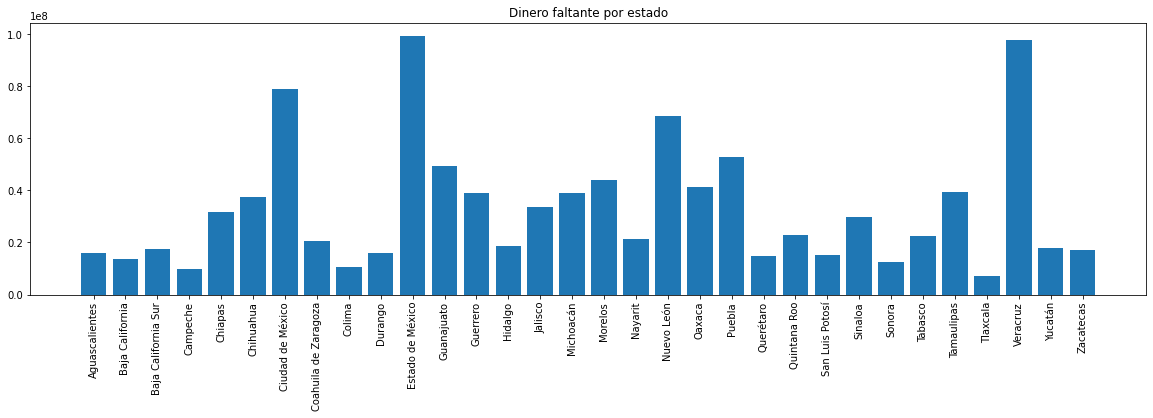

In [ ]:
fig, axs = plt.subplots(figsize=(20,5))
axs.bar(dinero_por_estado['Entidad Federativa'], dinero_por_estado['dinero_segun_auditorias'])
plt.xticks(rotation=90)
plt.title('Dinero faltante por estado')

plt.show()

#### CPI por estado

In [ ]:
ds_cpi_reducido =  ds_cpi[
                          list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]
ds_cpi_reducido = ds_cpi_reducido.set_index('estado').join(dinero_por_estado.set_index('Entidad Federativa')).reset_index().rename(columns={'index':'estado'})
ds_cpi_reducido.head(20)

,estado,CALIDAD DE VIDA,EQUIDAD E INCLUSIÓN SOCIAL,GOBERNANZA Y LEGISLACIÓN URBANA,INFRAESTRUCTURA DE DESARROLLO,PRODUCTIVIDAD,SOSTENIBILIDAD AMBIENTAL,sum,count,dinero_segun_auditorias
0,Aguascalientes,69.72,72.49,29.10,64.85,61.48,34.77,1.865944e+09,117,1.594824e+07
1,Aguascalientes,60.84,73.72,56.84,52.60,66.37,69.97,1.865944e+09,117,1.594824e+07
2,Aguascalientes,62.71,72.67,29.81,51.66,63.78,30.70,1.865944e+09,117,1.594824e+07
3,Baja California,54.24,72.79,42.42,56.56,54.44,76.70,1.714967e+09,126,1.361085e+07
4,Baja California,59.45,74.23,29.64,57.87,59.08,77.69,1.714967e+09,126,1.361085e+07
5,Baja California,52.26,74.27,30.31,49.31,52.41,65.43,1.714967e+09,126,1.361085e+07
6,Baja California,58.58,77.21,56.29,52.55,57.71,41.60,1.714967e+09,126,1.361085e+07
7,Baja California,58.05,72.66,59.53,57.15,64.28,34.72,1.714967e+09,126,1.361085e+07
8,Baja California Sur,64.22,72.85,71.32,74.05,60.26,46.92,2.942302e+09,169,1.741007e+07
9,Baja California Sur,55.58,71.21,49.50,66.66,66.20,47.28,2.942302e+09,169,1.741007e+07


#### Comparación del CPI en el sector de "GOBERNANZA Y LEGISLACIÓN URBANA" por estado

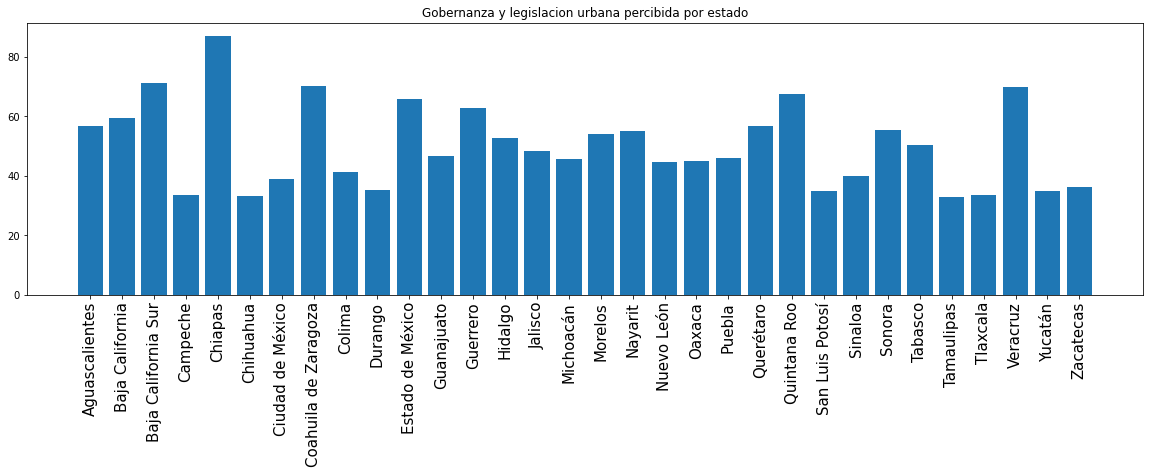

In [ ]:
fig, axs = plt.subplots(figsize=(20,5))
axs.bar(ds_cpi_reducido['estado'], ds_cpi_reducido['GOBERNANZA Y LEGISLACIÓN URBANA'])
plt.xticks(fontsize= 15, rotation=90)
plt.title('Gobernanza y legislacion urbana percibida por estado')

plt.show()

#### Comparación de CPI de los sectores principales por estado

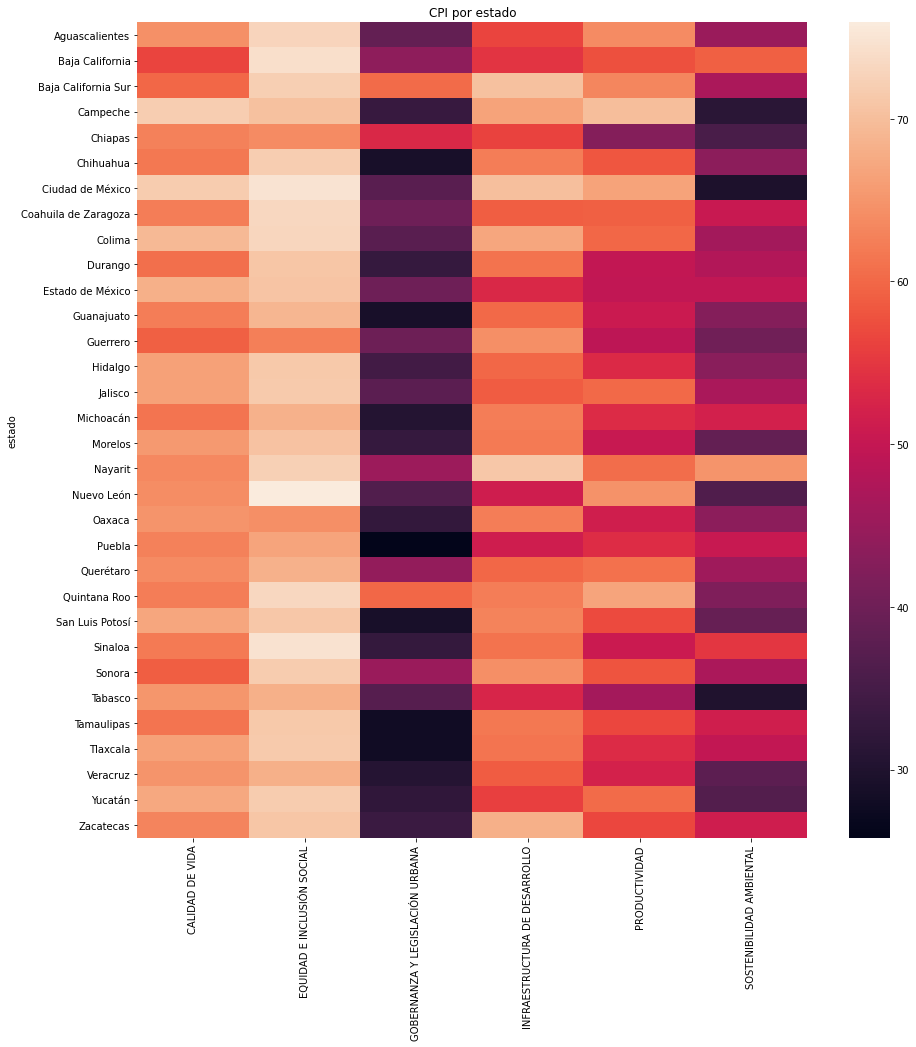

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, )
# fig.xticks(rotation=45)
plt.title('CPI por estado')
p1 = sns.heatmap(
    ds_cpi_reducido.groupby('estado').mean().drop(['dinero_segun_auditorias', 'sum', 'count'], axis=1),
    ax=ax)

#### Número de auditorías por estado

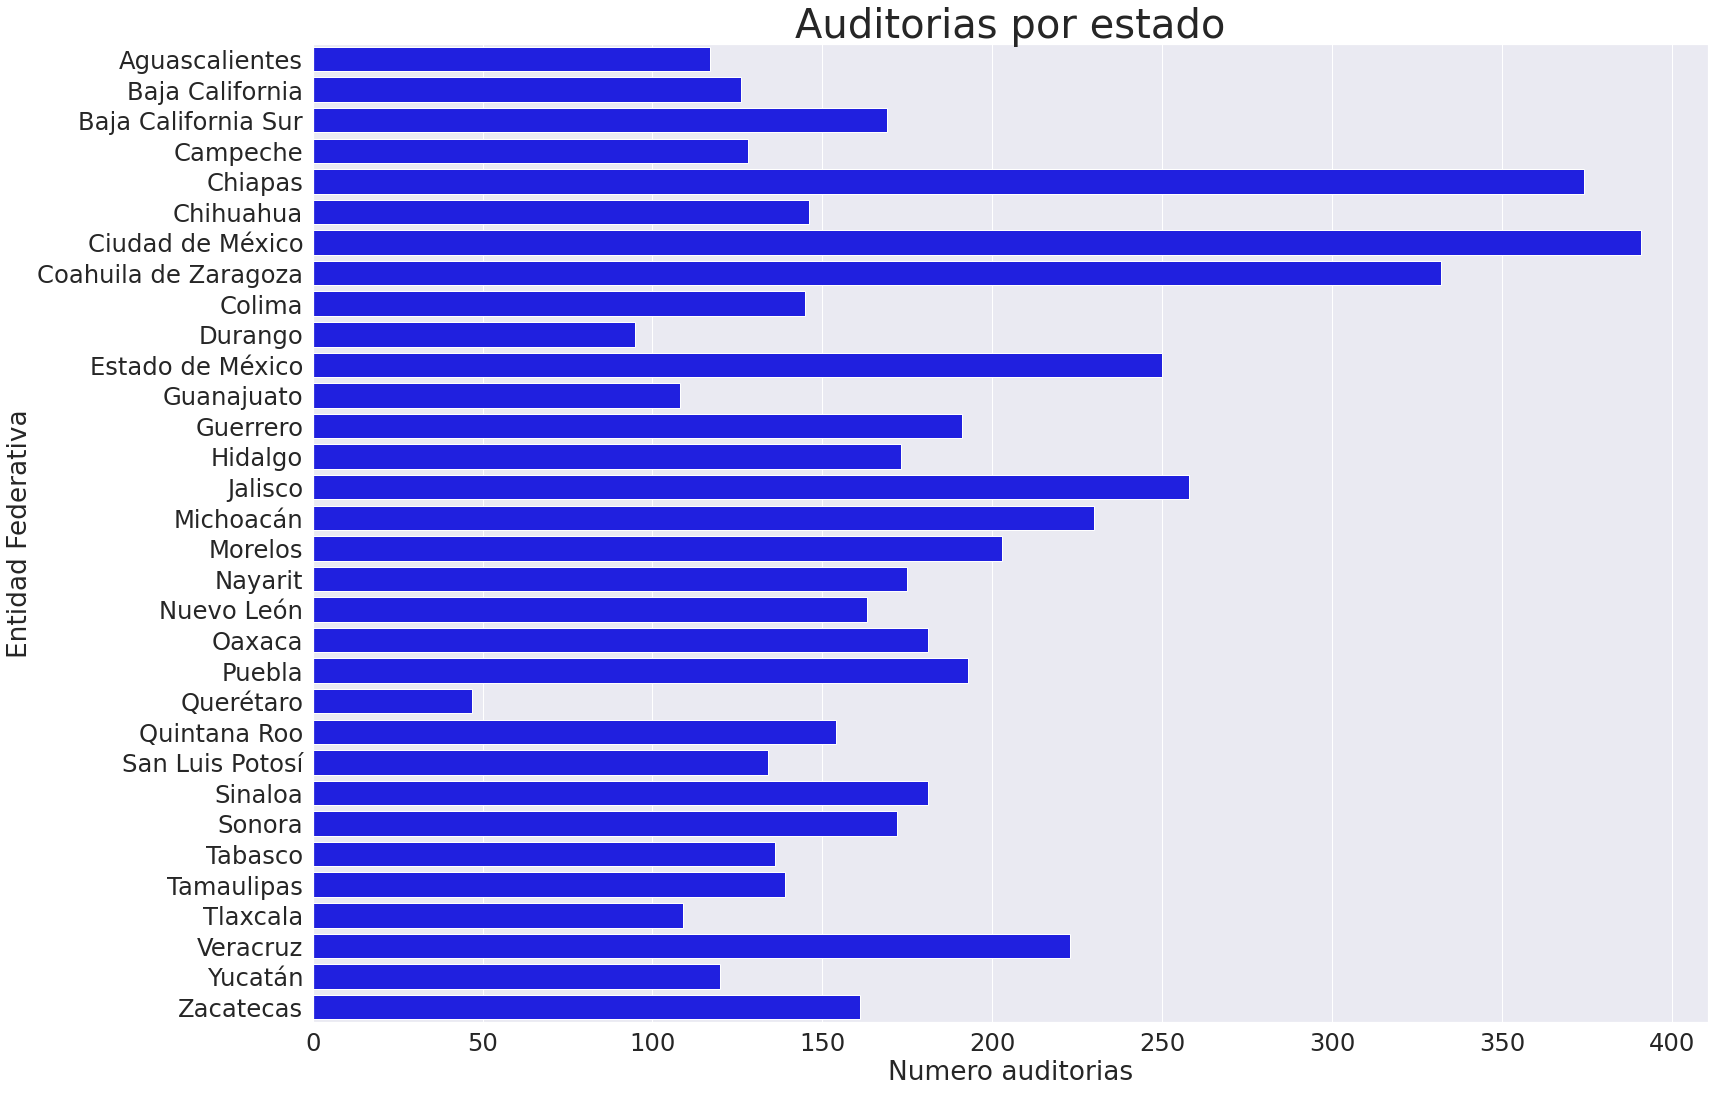

In [ ]:
plt.figure(figsize=(25,18))
plt.title("Auditorias por estado",fontsize=40)
sns.set(font_scale=2.2)
ax = sns.barplot(y="Entidad Federativa", x="count", data = dinero_por_estado,
            color="blue")
ax.set(xlabel='Numero auditorias')
plt.savefig("Auditorias.png", dpi = 300)

#### Importamos dataset de corrupción de nuevo para encontrar el porcentaje de incidencia de corrupción con respecto al número de auditorías por estado

In [ ]:
ds_incidencia = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Bedu-py/main/asf_2017-2019.csv',
     encoding='latin-1')

ds_incidencia = ds_incidencia[ds_incidencia['Tipo Auditoría'] != 'Forense']

print(ds_incidencia['Sector'].unique())
ds_incidencia.shape

['Aportaciones A Seguridad Social' 'Bienestar'
 'Desarrollo Agrario, Territorial y Urbano' 'Educación Pública'
 'Entidades No Sectorizadas' 'Gobernación' 'Hacienda y Crédito Público'
 'Instituciones Públicas de Educación Superior'
 'Medio Ambiente y Recursos Naturales'
 'Previsiones y Aportaciones Para Los Sistemas de Educación Básica, Normal, Tecnológica y de Adultos'
 'Ramos Generales 23, 33 y Otros' 'Salud'
 'Seguridad y Protección Ciudadana' 'Cultura'
 'Empresas Productivas Del Estado' 'Función Pública' 'Turismo']


(32332, 18)

#### Se descartan todas las auditorias incompletas o invalidas para este estudio

In [ ]:
ds_incidencia = ds_incidencia[~ds_incidencia['Estado de Trámite'].isin([
    '-', np.nan, 'No Notificado', 'Sustituida por Nueva Acción', 
    'Sobreseimiento'
])]

print(ds_incidencia.shape[0], 'casos validos')

25683 casos validos


#### Obtenemos las auditorias que presentaron casos de posible corrupcion

In [ ]:
ds_incidencia['incidencia'] = \
    ds_incidencia['Tipo Acción'].isin([
        'Pliego de Observaciones', 
        'Promoción de Responsabilidad Administrativa Sancionatoria', 
        'Informe de Presunta Responsabilidad Administrativa',
        'Promoción del Ejercicio de la Facultad de Comprobación Fiscal']) &\
    (~ds_incidencia['Texto Acción'].isna()) &\
    (ds_incidencia['Texto Acción'] != '-')

ds_incidencia.head()
print(ds_incidencia['incidencia'].sum(), 'casos de posible corrupcion')

17803 casos de posible corrupcion


#### Porcentaje de incidencia resultante

In [ ]:
print(
    'El porcentaje de incidencia encontrado en auditorias de la ASF es de',
    round((ds_incidencia['incidencia'].sum()/ds_incidencia.shape[0]) * 100),
    '%'
)

El porcentaje de incidencia encontrado en auditorias de la ASF es de 69 %


### Datasets de uso común

In [ ]:
ds_dinero = ds.dropna(subset=['desaparecido'], how='any')

# Preguntas

- ¿Cuánto dinero perdido tenemos actualmente?
- ¿Existe una relación entre la cantidad de dinero perdido de un estado y su CPI?
- ¿La relación entre en la corrupcion y el CPI es positiva o negativa?
- ¿Cuáles son los estados con peor manejo de recursos?
- ¿Cómo varia el mal manejo de los recursos con respecto al tiempo?
- ¿Cuáles son las organizaciones gubernamentales con peor manejo de los recursos publicos?
- ¿Cuáles son los sectores peor administrados?
- ¿Existe alguna relación entre el sector y eficiencia de la resolución de las auditorías?
- ¿Cuál es el sector y la entidad federativa mas auditada?

## ¿Cuánto dinero perdido tenemos actualmente?

In [ ]:
assert ds['desaparecido'].sum() == dinero_por_estado["sum"].sum()

print(
    'Existe un total de:',
    "${:,.2f}".format(dinero_por_estado["sum"].sum()),
    'pesos mexicanos desaparecidos en el periodo del 2014 al 2019.'
)

Existe un total de: $215,760,701,632.00 pesos mexicanos desaparecidos en el periodo del 2014 al 2019.


## ¿Cuáles son los estados con peor manejo de recursos?

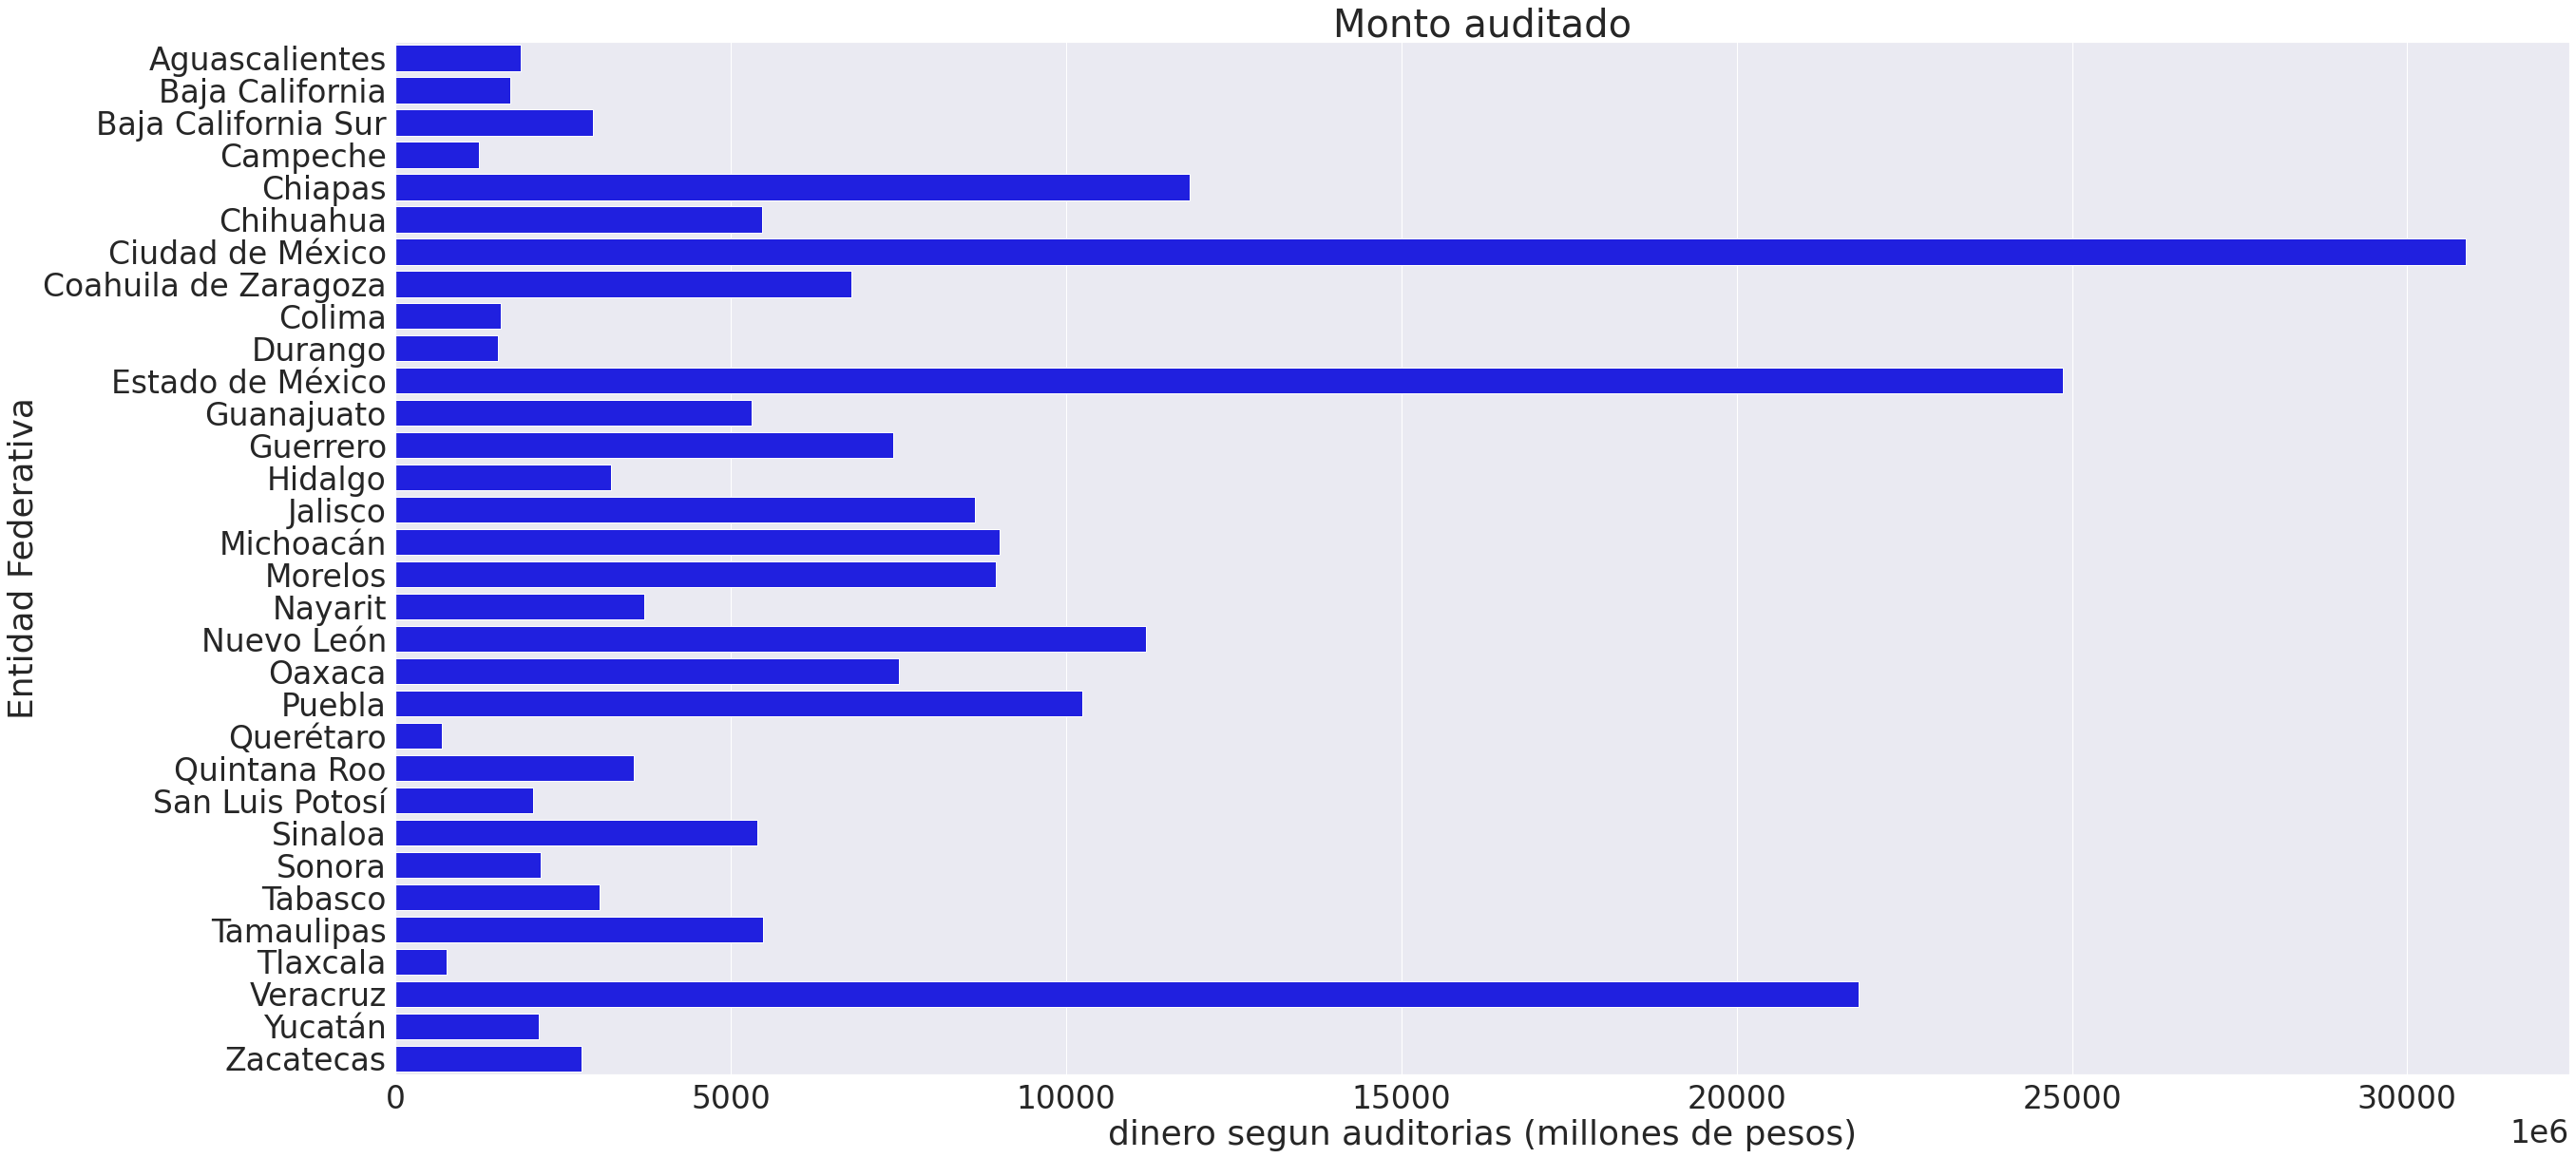

In [ ]:
plt.figure(figsize=(41,20))
plt.title("Monto auditado",fontsize=40)
sns.set(font_scale=3)
ax = sns.barplot(y="Entidad Federativa", x="sum", data = dinero_por_estado,color = "blue"
            )
ax.set(xlabel = 'dinero segun auditorias (millones de pesos)')
ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))
plt.savefig("MontoAuditado.png")

Dado que en el grafico únicamente se considera el monto que se mocharon, se decidió normalizar el monto mochado respecto al número de auditorias realizadas para el estado, para así revelar información que pudiese estar enmascarada por este hecho

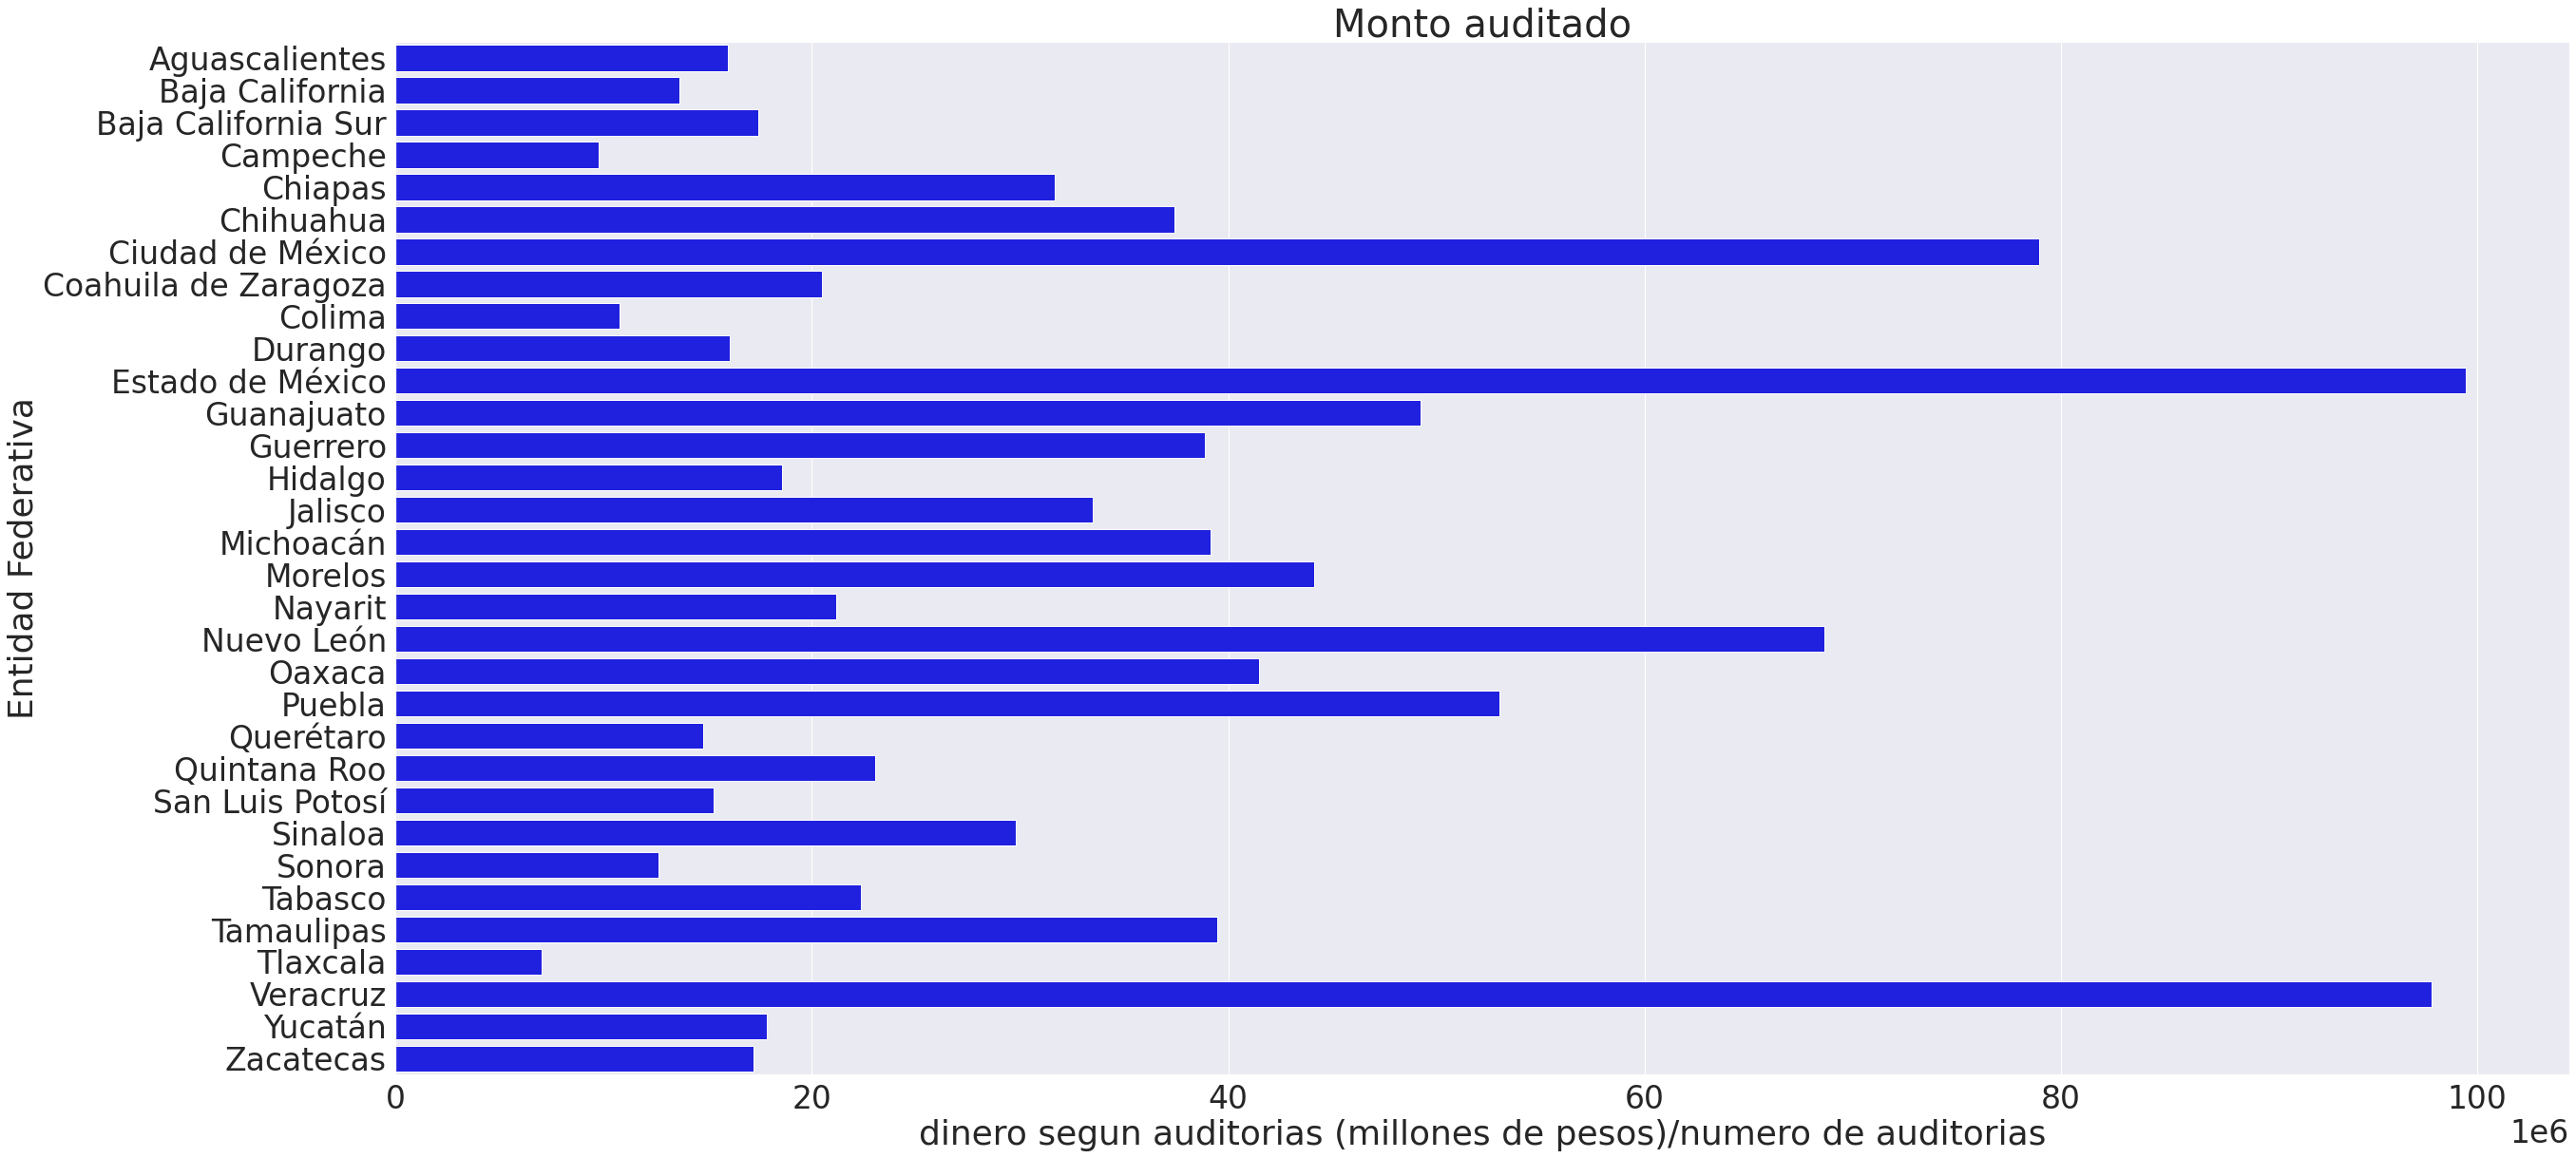

In [ ]:
aiuda = dinero_por_estado.sort_values(by = "count")
plt.figure(figsize=(41,20))
plt.title("Monto auditado",fontsize=40)
sns.set(font_scale=3)
ax = sns.barplot(y="Entidad Federativa", x="dinero_segun_auditorias", data = dinero_por_estado, color = "blue"
            )
ax.set(xlabel = 'dinero segun auditorias (millones de pesos)/numero de auditorias')
ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))
plt.savefig("MontoAuditadoNormal.png")

Con este gráfico podemos observar que los estados que más dinero se mocharon son:
- Estado de México
- Veracruz
- Ciudad de México
- Nuevo León
- Puebla

## ¿Como varía el mal manejo de los recursos con respecto al tiempo?

Para este análisis se consideraró, de la misma manera, el total de dinero mochado dividido por el numero de auditorias por año.

Se discutirán los estados que a nivel nacional son los que presentan un mayor moche de dinero

In [ ]:
ds_tiempo = ds.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa','Año Cuenta Pública'])['desaparecido'].aggregate(['sum', 'count'])
ds_tiempo = ds_tiempo.reset_index()
ds_tiempo['dinero_por_auditoria'] = ds_tiempo['sum']/ds_tiempo['count']
ds_tiempo.head(5)

,Entidad Federativa,Año Cuenta Pública,sum,count,dinero_por_auditoria
0,Aguascalientes,2014,1.498536e+08,11,1.362306e+07
1,Aguascalientes,2015,1.335622e+06,1,1.335622e+06
2,Aguascalientes,2016,2.490442e+08,31,8.033683e+06
3,Aguascalientes,2017,5.225548e+07,6,8.709246e+06
4,Aguascalientes,2018,1.188667e+09,49,2.425851e+07


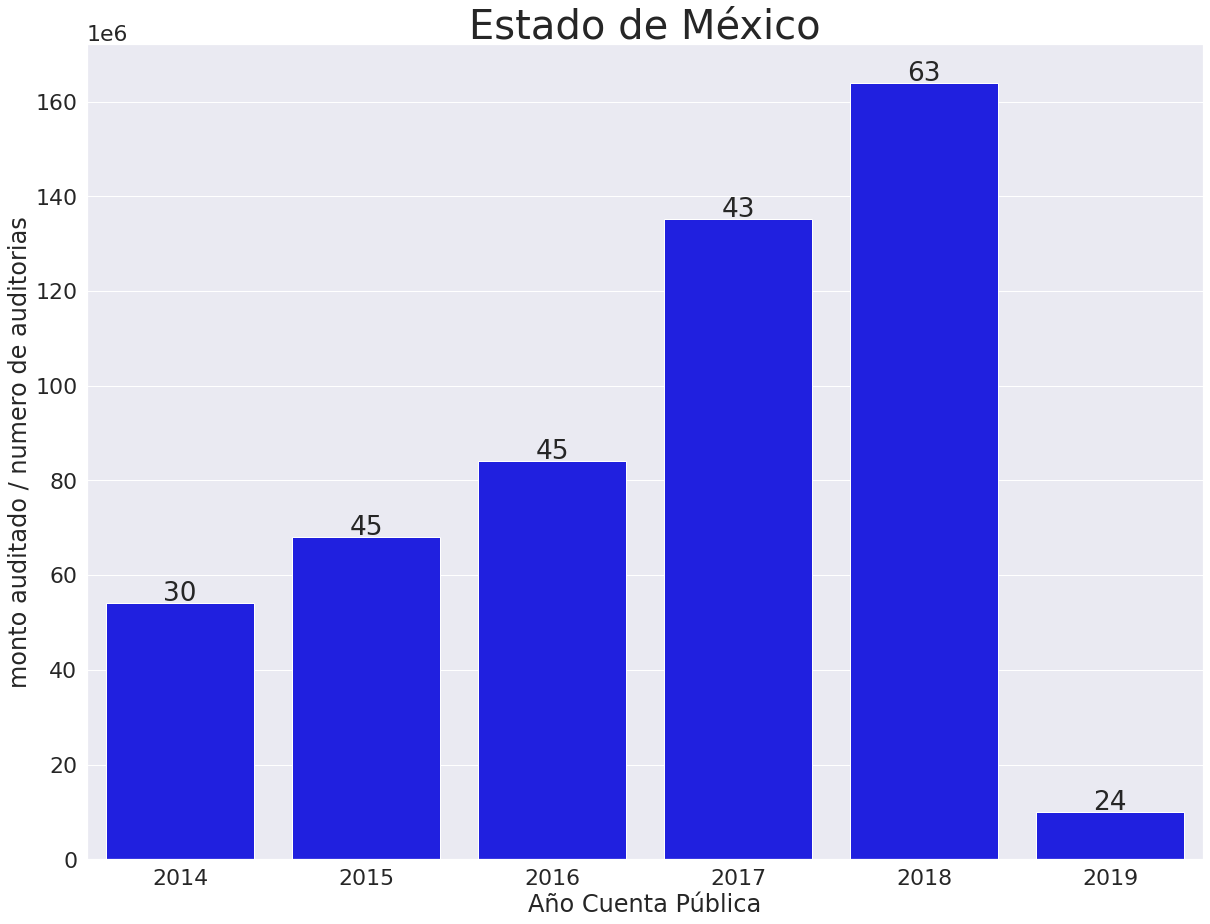

In [ ]:
estado = "Estado de México"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

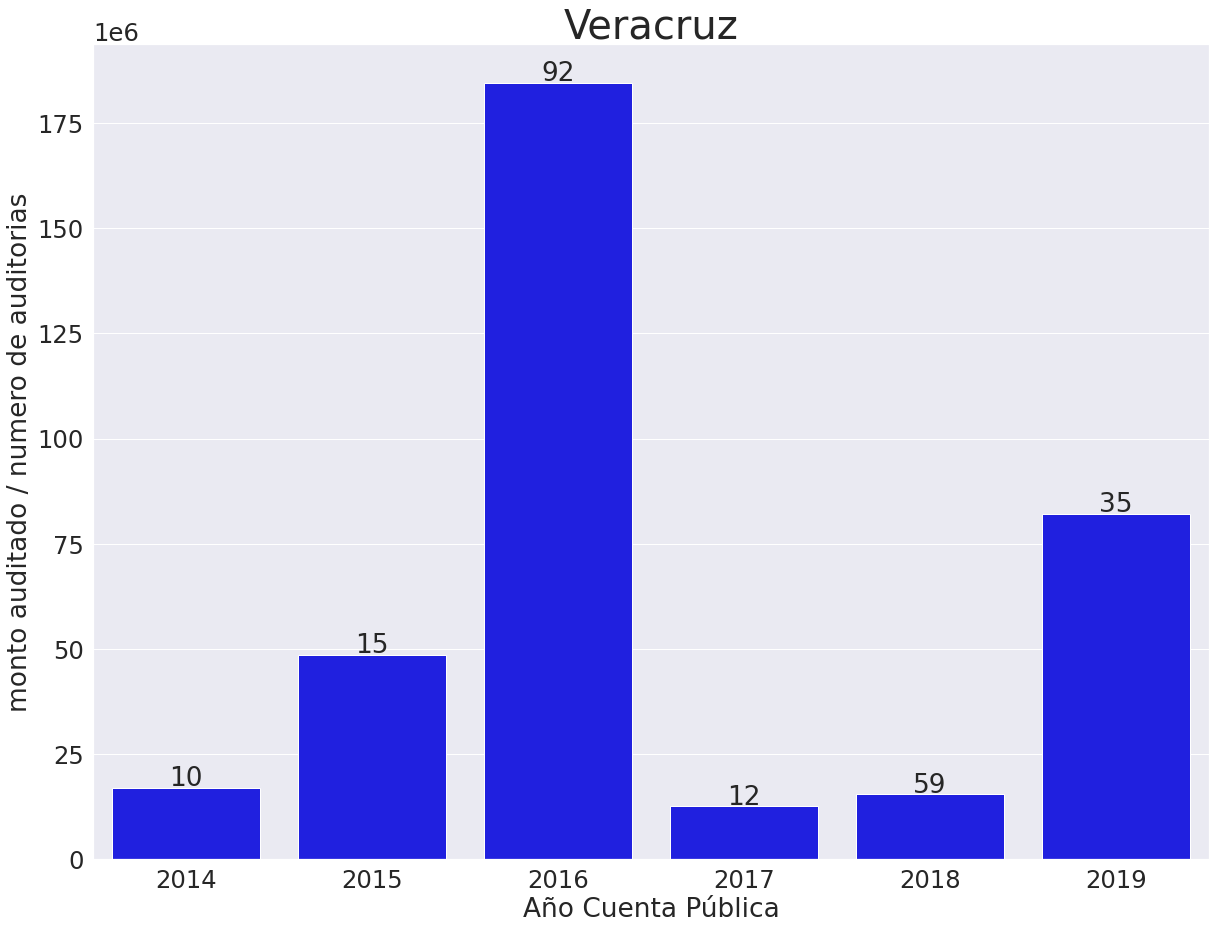

In [ ]:
estado = "Veracruz"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

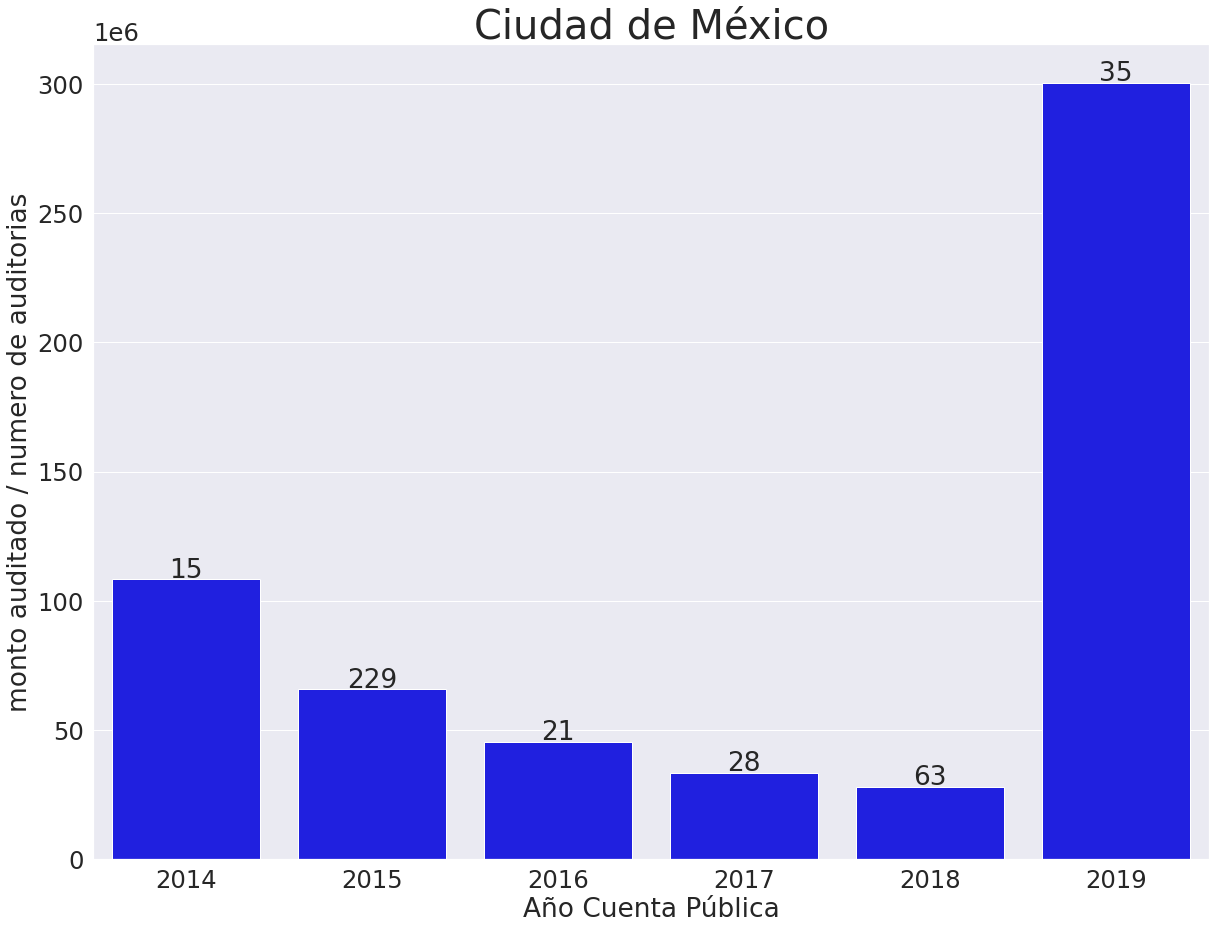

In [ ]:
estado = "Ciudad de México"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

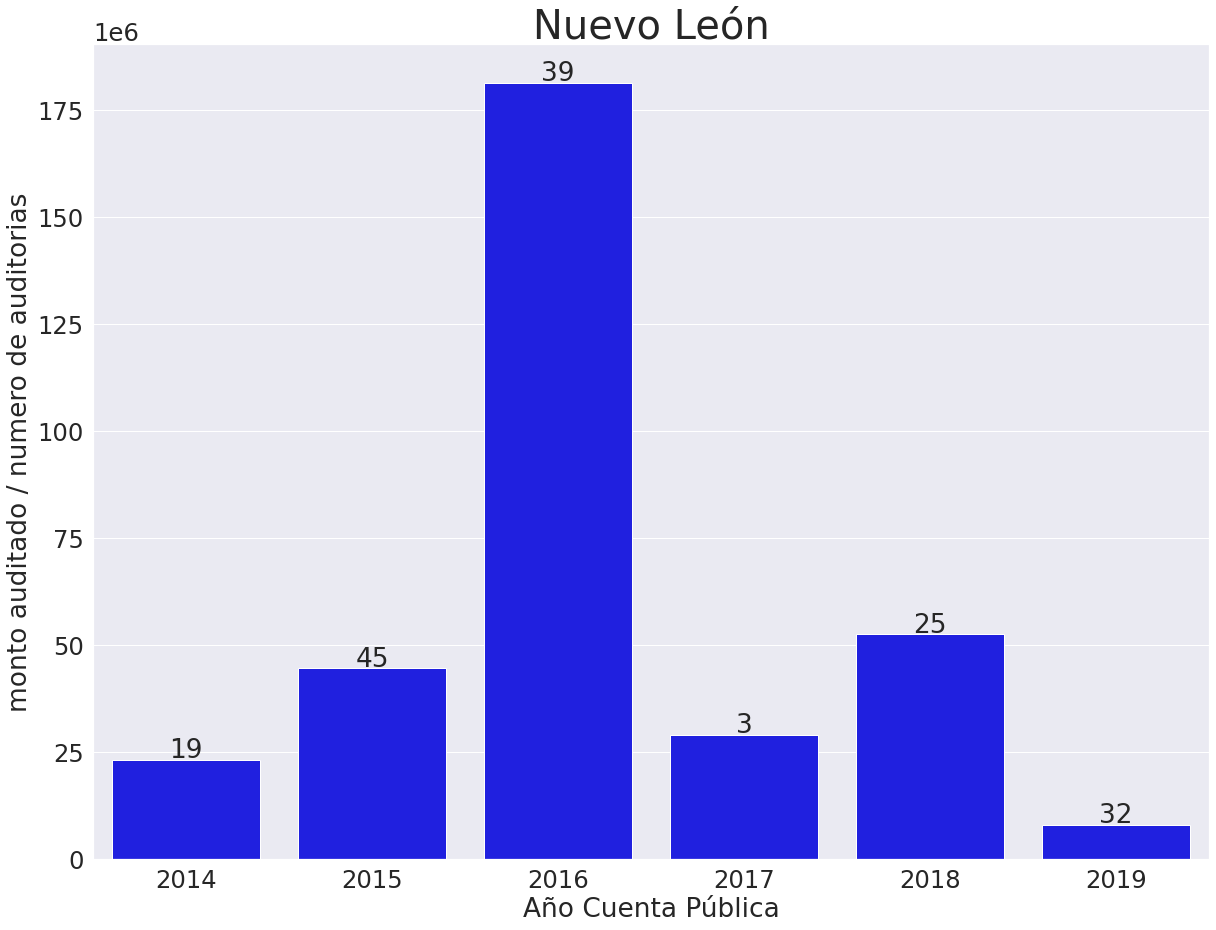

In [ ]:
estado = "Nuevo León"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

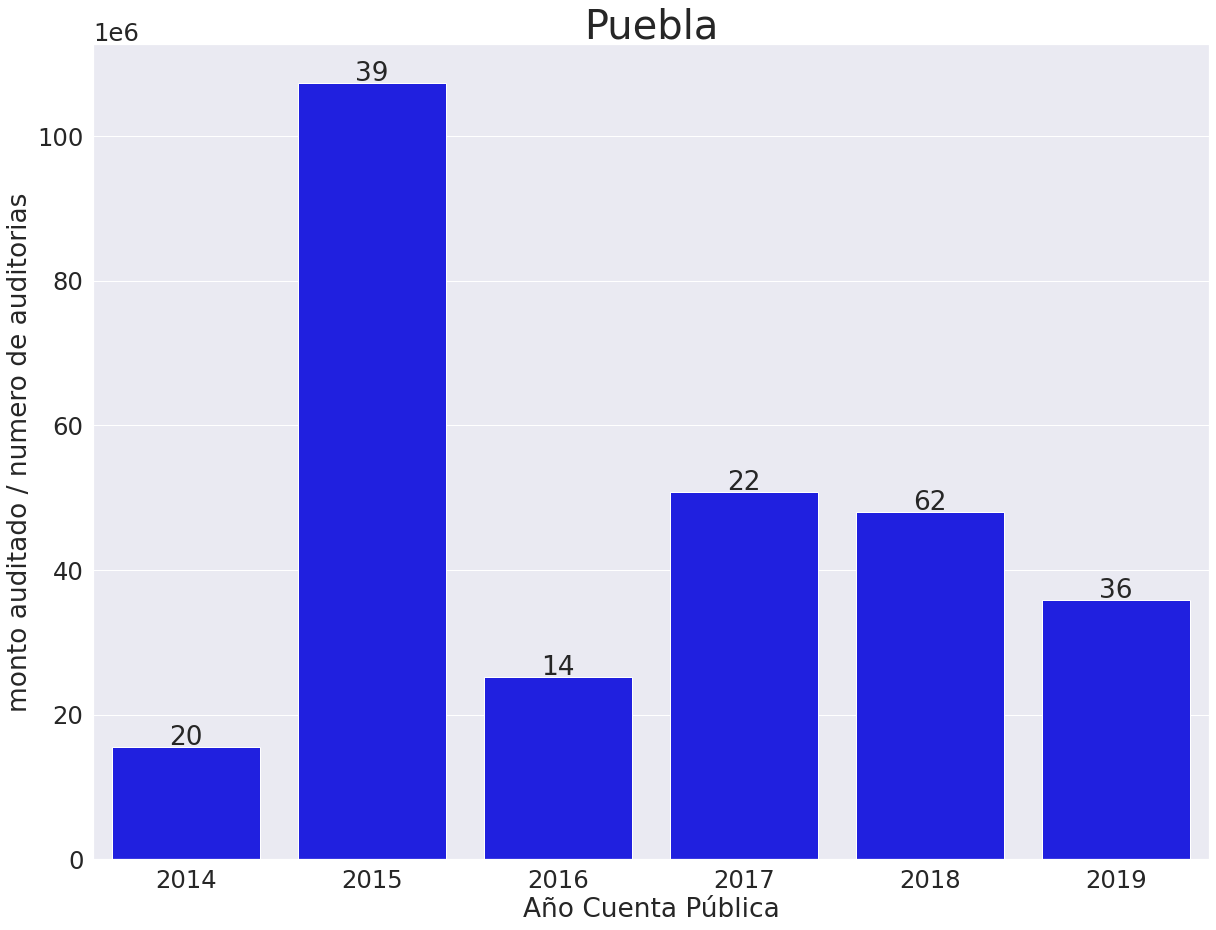

In [ ]:
estado = "Puebla"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

### Discusion

Se observa que no hay una clara tendencia en los distintos estados. Sin embargo, el comportamiento de cada estado puede explicarse de acuerdo a su contexto local.

## ¿Existe una relación entre la cantidad de dinero perdido de un estado y su CPI?  ¿La relación entre en la corrupcion y el CPI es positiva o negativa?


In [ ]:
# CORRELACIÓNES ENTRE LA SUMA DE DINERO ENVUELTO EN CORRUPCIÓN Y LOS SECTORES PRINCIPALES DEL CPI

ds_cpi_reducido_corr = ds_cpi_reducido 
ds_cpi_reducido_corr.drop(["count"], axis=1, inplace=True)

## Matriz de correlación
corr_mat = ds_cpi_reducido_corr.corr()

## Colorear mayor correlación
def text_format(val):
    color = 'salmon' if (val > 0.37 and val < 0.372) else None
    color2 = 'black' if (val > 0.37 and val < 0.372) else None
    return 'background-color: %s; color: %s' %(color,color2)

corr_mat.style.applymap(text_format)

,CALIDAD DE VIDA,EQUIDAD E INCLUSIÓN SOCIAL,GOBERNANZA Y LEGISLACIÓN URBANA,INFRAESTRUCTURA DE DESARROLLO,PRODUCTIVIDAD,SOSTENIBILIDAD AMBIENTAL,sum,dinero_segun_auditorias
CALIDAD DE VIDA,1.000000,0.119677,0.096830,0.054866,-0.020260,-0.046501,0.371003,0.296489
EQUIDAD E INCLUSIÓN SOCIAL,0.119677,1.000000,-0.121311,0.149755,0.362585,0.191016,0.052018,0.042722
GOBERNANZA Y LEGISLACIÓN URBANA,0.096830,-0.121311,1.000000,-0.059342,-0.079957,-0.077338,0.063513,-0.055251
INFRAESTRUCTURA DE DESARROLLO,0.054866,0.149755,-0.059342,1.000000,0.290803,-0.026446,-0.100310,-0.211233
PRODUCTIVIDAD,-0.020260,0.362585,-0.079957,0.290803,1.000000,0.022934,-0.056736,-0.092669
SOSTENIBILIDAD AMBIENTAL,-0.046501,0.191016,-0.077338,-0.026446,0.022934,1.000000,-0.070234,-0.014923
sum,0.371003,0.052018,0.063513,-0.100310,-0.056736,-0.070234,1.000000,0.912085
dinero_segun_auditorias,0.296489,0.042722,-0.055251,-0.211233,-0.092669,-0.014923,0.912085,1.000000


In [ ]:
# PARA TODOS LOS SECTORES Y SUBSECTORES INDIVIDUALES DEL CPI

columnas_cpi=list(ds_cpi.columns)
columnas_cpi.pop(0)
columnas_cpi.pop(0)
dic_corr={}
for i in columnas_cpi:
    dic_corr[i]=ds_cpi[i].corr(ds_cpi_reducido["dinero_segun_auditorias"])  #sum
dic_corr=sorted(dic_corr.items(), key=lambda x: x[1], reverse=True)

dic_corr_df = pd.DataFrame(dic_corr, columns=['Subsector', 'Correlacion con suma de dinero'])



In [ ]:
## Colorear mayor correlación
def text_format(val):
    if isinstance(val, float): #dic_corr_df['Correlacion con suma de dinero']:
      color = 'salmon' if (val > 0.307 and val < 0.3074) else None
      color2 = 'black' if (val > 0.307 and val < 0.3074) else None
      return 'background-color: %s; color: %s' %(color,color2)

    else:
      color = 'salmon' if val =='Densidad poblacional' else None
      color2 = 'black' if val =='Densidad poblacional' else None
      return 'background-color: %s; color: %s' %(color,color2)

In [ ]:
dic_corr_df.style.applymap(text_format)

,Subsector,Correlacion con suma de dinero
0,Densidad poblacional,0.307384
1,CALIDAD DE VIDA,0.296489
2,Coeﬁciente de Gini,0.207991
3,Áreas verdes per cápita,0.186628
4,Acceso a Internet,0.092522
5,Espacio habitable suﬁciente,nan
6,Esperanza de vida al nacer,0.196668
7,Seguridad y protección,0.186500
8,Tasa de homicidios,0.186500
9,Salud,0.181886


La mayor correlación de la suma del dinero perdido por corrupcion se obtuvo con el sector "CALIDAD DE VIDA" del CPI. Esta correlación fue positiva e igual a 0.37.

Cuando comparamos la suma del dinero perdido con todos los sectores y subsectores, el subsector con mayor correlación positiva fue "Densidad poblacional" con 0.307. El subsector con una correlación más negativa "Tratamiento de aguas residuales" y fue de -0.28.

## ¿Cuáles son las organizaciones gubernamentales con peor manejo de los recursos publicos?


In [ ]:
ds_org = ds_dinero.groupby('Ente a quien se dirige la Acción')
ds_org = ds_org['desaparecido'].aggregate(['count', 'sum', 'mean'])
ds_org = ds_org.reset_index()
ds_org.head(5)

,Ente a quien se dirige la Acción,count,sum,mean
0,"Alcaldía Benito Juárez, Ciudad de México",1,6109360.0,6109360.0
1,"Alcaldía Cuajimalpa de Morelos, Ciudad de México",1,1348454.0,1348454.0
2,"Alcaldía Cuauhtémoc, Ciudad de México",4,24563850.0,6140962.5
3,"Alcaldía Gustavo A. Madero, Ciudad de México",5,305781671.0,61156334.2
4,"Alcaldía Iztacalco, Ciudad de México",1,37036.0,37036.0


In [ ]:
ds_top_99 = ds_org[ds_org['mean'] >= ds_org['mean'].quantile(.99)]
ds_top_99

,Ente a quien se dirige la Acción,count,sum,mean
46,Instituto Mexicano del Seguro Social,1,1.342933e+09,1.342933e+09
238,"Municipio de León, Guanajuato",5,2.319774e+09,4.639549e+08
358,"Municipio de San Pedro Garza García, Nuevo León",1,3.884771e+08,3.884771e+08
482,Secretaría de Salud,2,1.339713e+09,6.698563e+08
486,"Televisora de Hermosillo, S. A. de C. V.",1,2.718917e+08,2.718917e+08
493,Universidad Autónoma de Chihuahua,3,8.268089e+08,2.756030e+08


[Text(0.5, 0, 'Dinero promedio por auditoria (miles de millones)')]

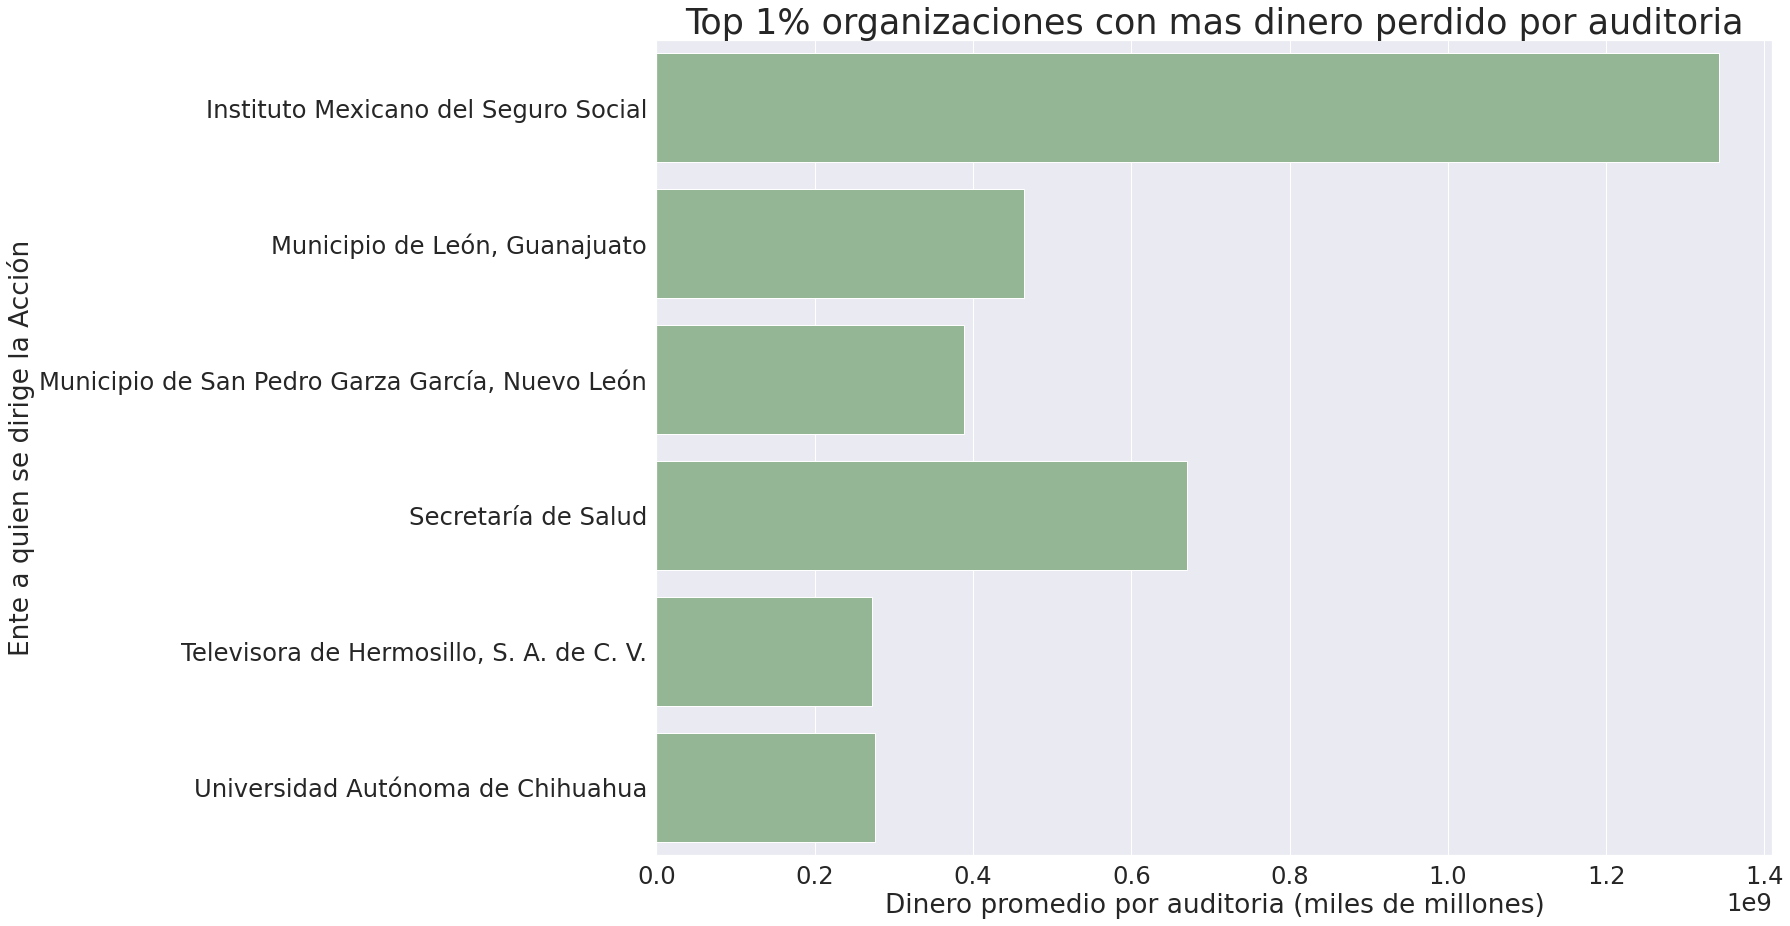

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Top 1% organizaciones con mas dinero perdido por auditoria",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Ente a quien se dirige la Acción", x="mean", data = ds_top_99, color = "darkseagreen")
ax.set(xlabel = 'Dinero promedio por auditoria (miles de millones)')

# ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

In [ ]:
ds_top_99 = ds_org[ds_org['count'] >= ds_org['count'].quantile(.99)]
ds_top_99.head()

,Ente a quien se dirige la Acción,count,sum,mean
19,Gobierno del Estado de Chiapas,234,9.773112e+09,4.176543e+07
21,Gobierno del Estado de Coahuila de Zaragoza,173,5.899674e+09,3.410216e+07
27,Gobierno del Estado de Jalisco,178,5.566354e+09,3.127165e+07
28,Gobierno del Estado de Michoacán de Ocampo,167,8.454227e+09,5.062412e+07
29,Gobierno del Estado de Morelos,170,8.399924e+09,4.941132e+07


[Text(0, 0.5, 'Ente'), Text(0.5, 0, 'Cantidad de auditorias realizadas')]

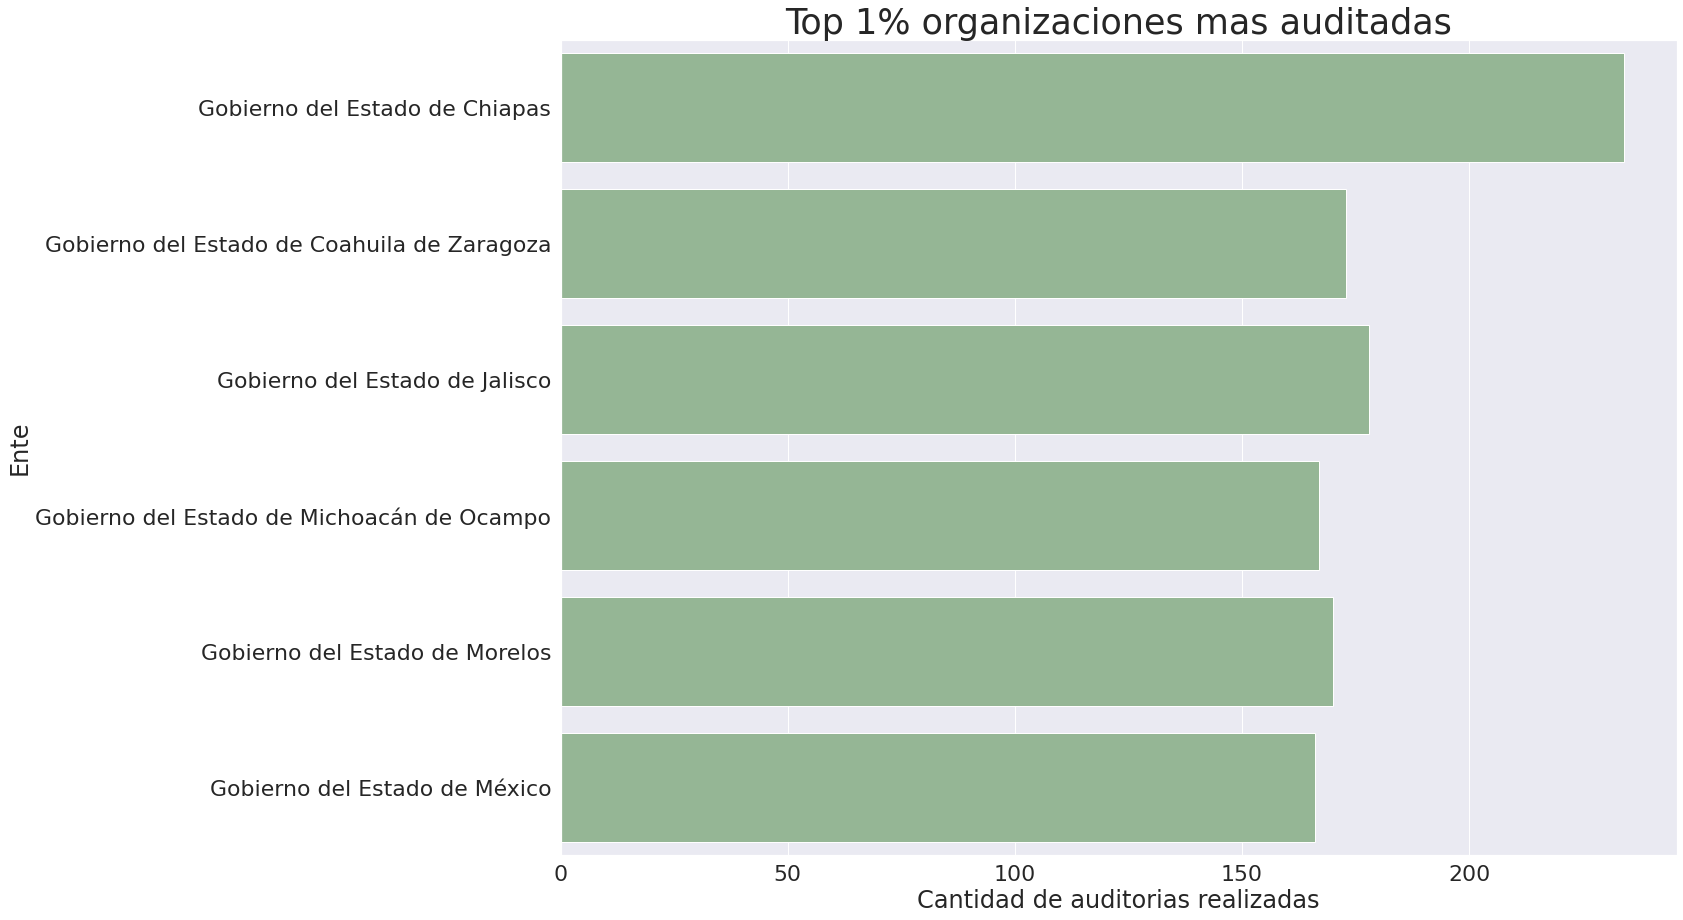

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Top 1% organizaciones mas auditadas",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Ente a quien se dirige la Acción", x="count", data = ds_top_99, color = "darkseagreen")
ax.set(
    xlabel = 'Cantidad de auditorias realizadas',
    ylabel='Ente'
)
# ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

## ¿Cuáles son los sectores peor administrados?

In [ ]:
ds_sector = ds_dinero.groupby('Sector')
ds_sector = ds_sector['desaparecido'].aggregate(['count', 'sum', 'mean'])
ds_sector = ds_sector.reset_index()
ds_sector

,Sector,count,sum,mean
0,Aportaciones A Seguridad Social,1,1.342933e+09,1.342933e+09
1,Cultura,16,1.645452e+08,1.028408e+07
2,Educación Pública,55,1.004372e+09,1.826132e+07
3,Hacienda y Crédito Público,126,4.295576e+09,3.409188e+07
4,Instituciones Públicas de Educación Superior,321,1.614851e+10,5.030688e+07
5,Previsiones y Aportaciones Para Los Sistemas d...,8,4.102477e+08,5.128096e+07
6,"Ramos Generales 23, 33 y Otros",5154,1.828826e+11,3.548363e+07
7,Salud,33,9.438853e+09,2.860258e+08
8,Seguridad y Protección Ciudadana,10,7.304049e+07,7.304049e+06


[Text(0, 0.5, 'Ente'), Text(0.5, 0, 'Dinero promedio')]

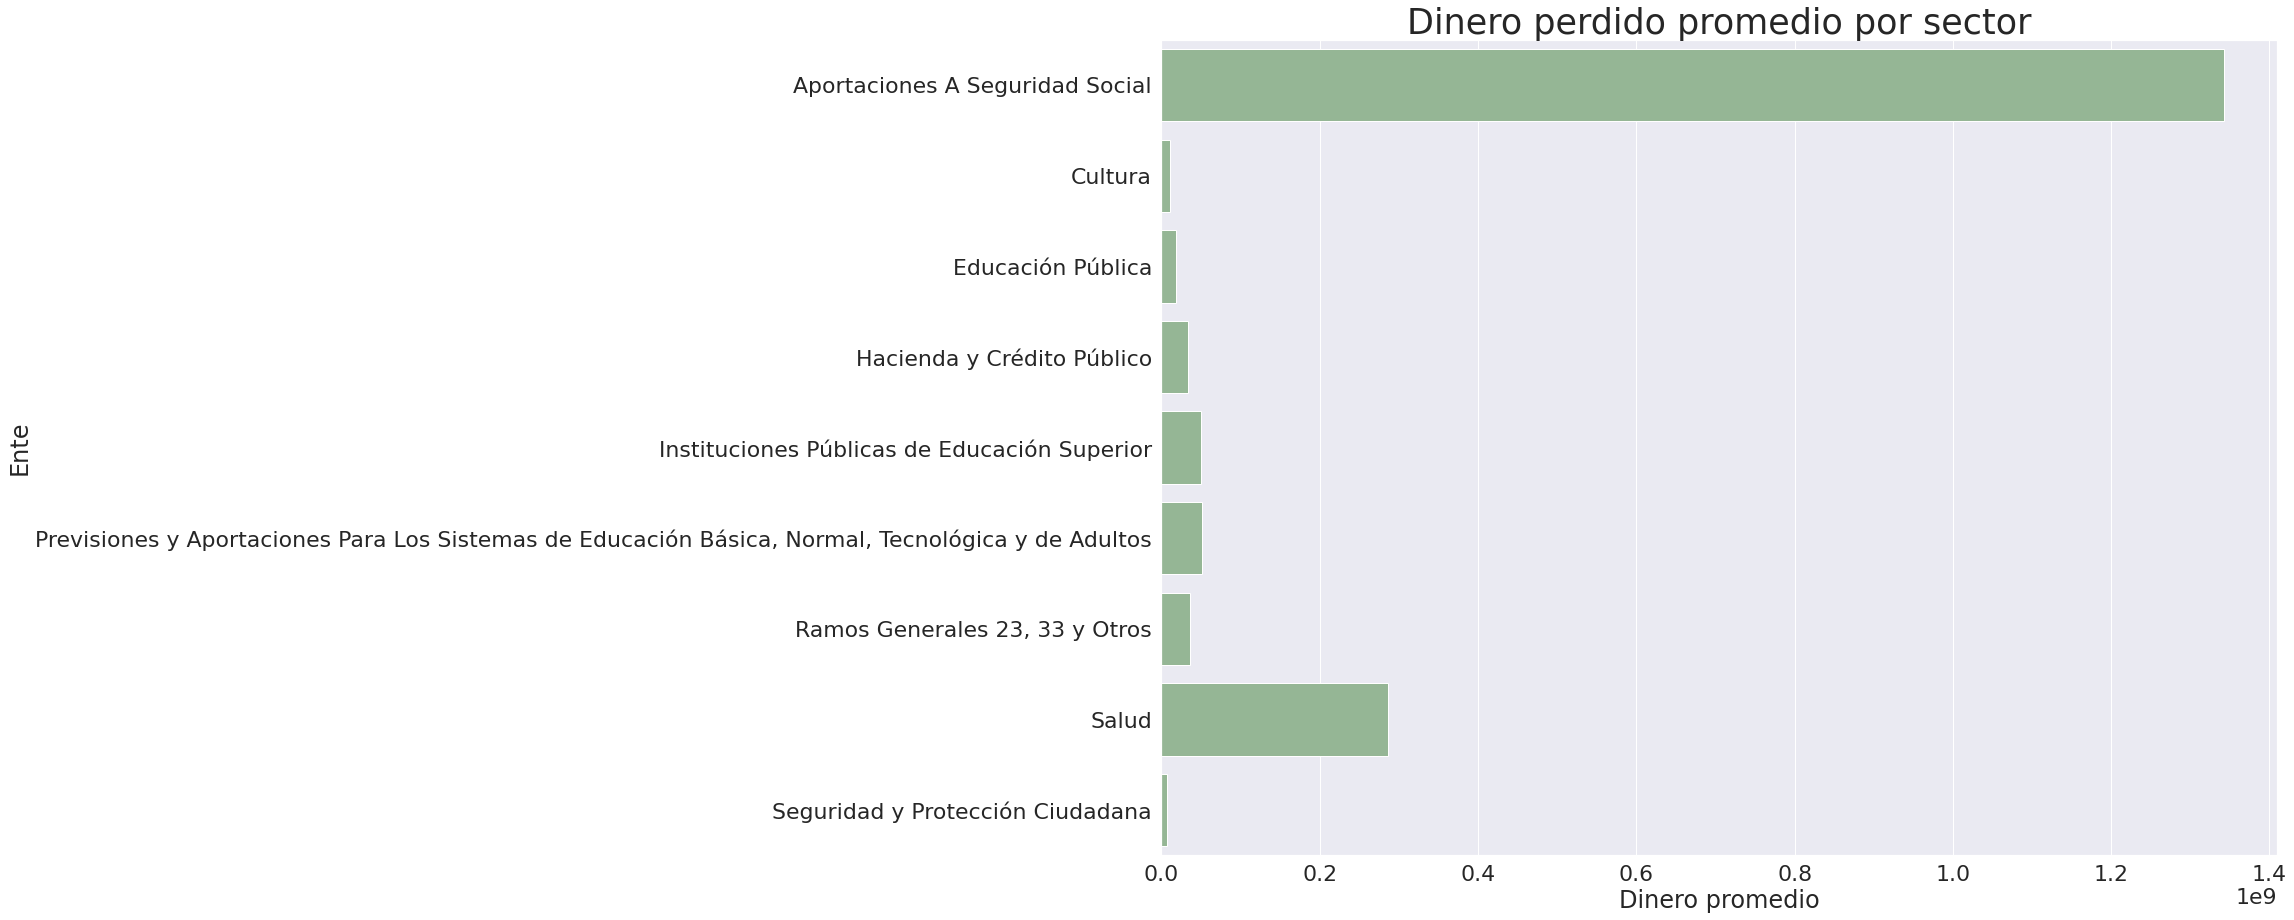

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dinero perdido promedio por sector",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Sector", x="mean", data = ds_sector, color = "darkseagreen")
ax.set(
    xlabel = 'Dinero promedio',
    ylabel='Ente'
)

[Text(0, 0.5, 'Ente'), Text(0.5, 0, 'Auditorias realizadas')]

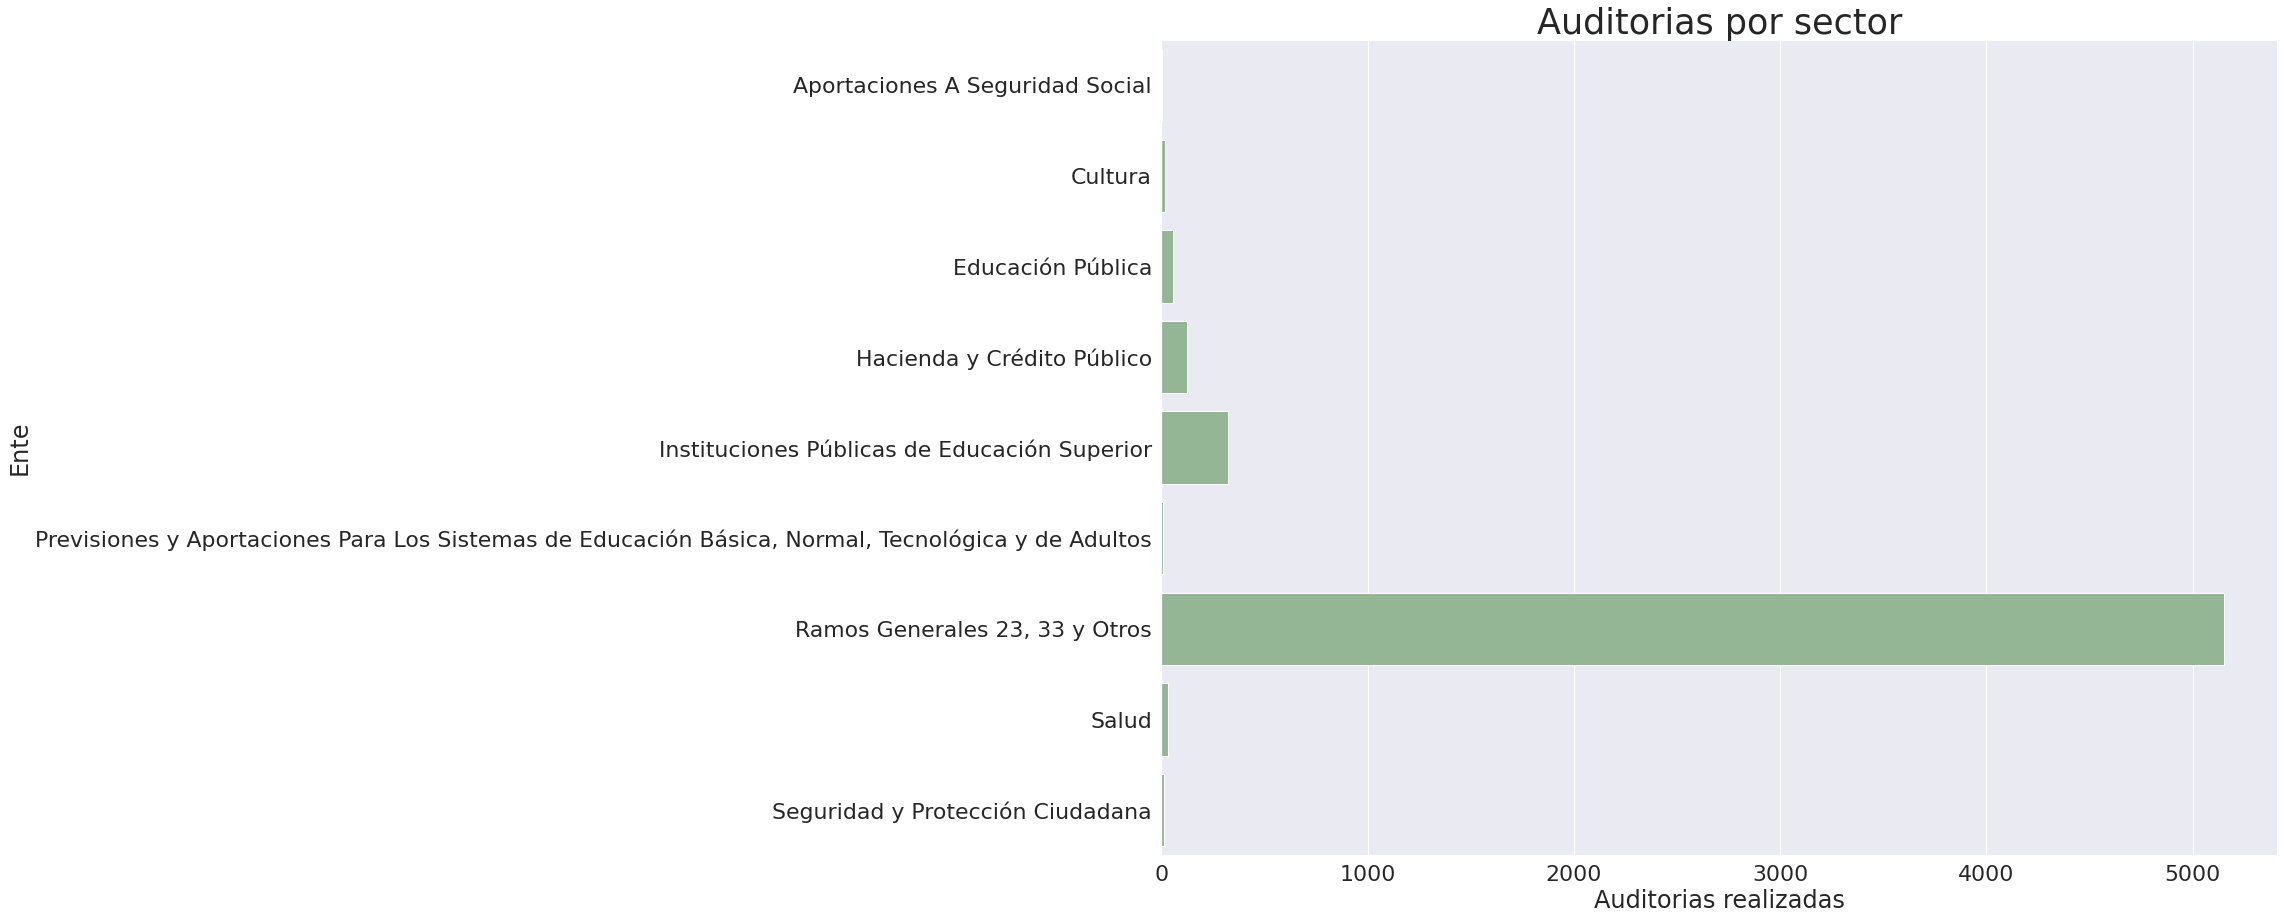

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Auditorias por sector",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Sector", x="count", data = ds_sector, color = "darkseagreen")
ax.set(
    xlabel = 'Auditorias realizadas',
    ylabel='Ente'
)

## ¿Existe alguna relación entre el sector y eficiencia de la resolución de las auditorias?


In [ ]:
ds_sector = ds.groupby(['Sector'])['terminado'].aggregate(['sum', 'count'])
ds_terminados = ds_sector.reset_index()
ds_terminados['no terminado'] = ds_terminados['count'] - ds_terminados['sum']

ds_terminados.__getitem__('Sector').__setitem__(10, 'Previsiones y aportaciones para educacion') 
ds_terminados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Sector,sum,count,no terminado
0,Aportaciones A Seguridad Social,3,5,2
1,Bienestar,15,15,0
2,Cultura,53,62,9
3,"Desarrollo Agrario, Territorial y Urbano",3,3,0
4,Educación Pública,253,272,19
5,Entidades No Sectorizadas,1,1,0
6,Gobernación,3,3,0
7,Hacienda y Crédito Público,312,366,54
8,Instituciones Públicas de Educación Superior,495,870,375
9,Medio Ambiente y Recursos Naturales,2,3,1


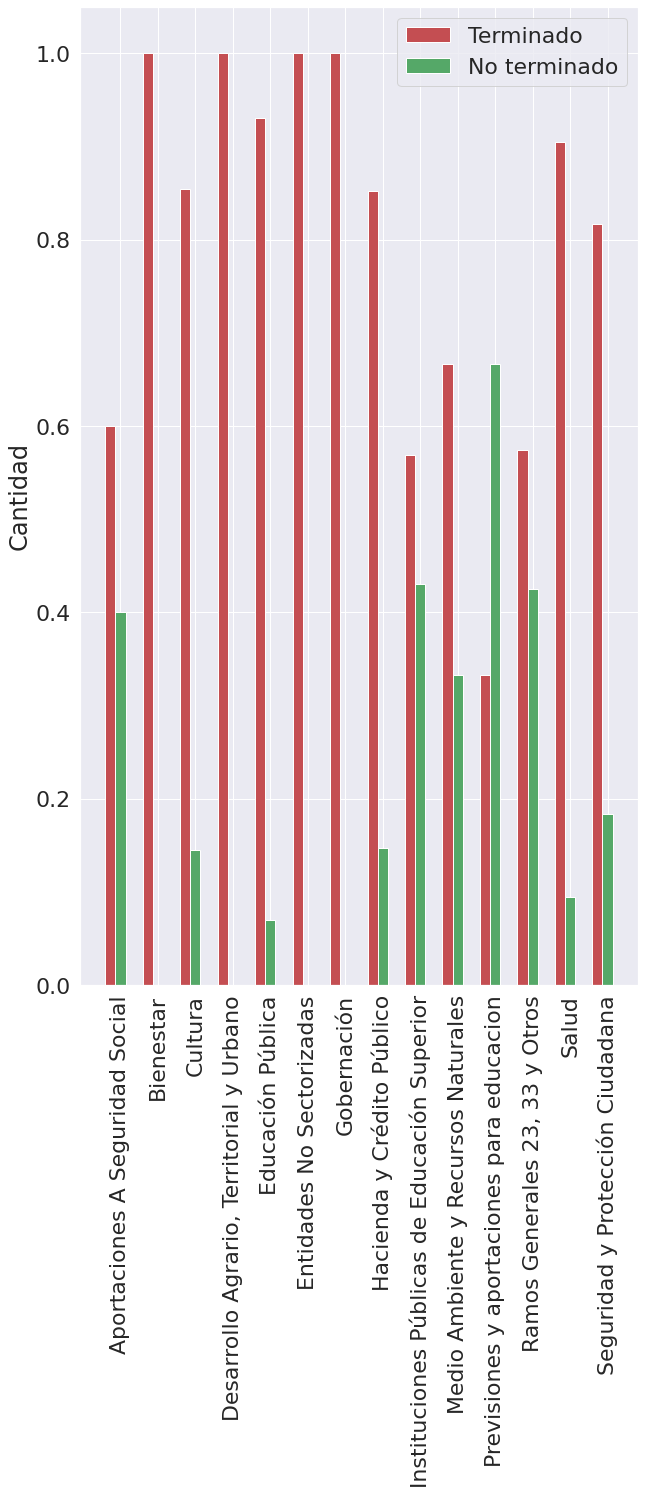

In [ ]:
N = len(ds_terminados)
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize= [10,18])

ax = fig.add_subplot(111)

yvals = ds_terminados['sum']/ds_terminados['count']
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = ds_terminados['no terminado']/ds_terminados['count']
rects2 = ax.bar(ind+width, zvals, width, color='g')
# kvals = [11,12,13]
# rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Cantidad')
ax.set_xticks(ind+width)
ax.set_xticklabels( ds_terminados['Sector'] )
ax.legend( (rects1[0], rects2[0]), ('Terminado', 'No terminado') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)

#Cruza los dedos :v
plt.xticks(rotation=90)
plt.show()


# Anexos
### Video explicativo
<p align="center">

[![Alt text](https://github.com/Erick-INCS/Bedu-py/raw/main/img/slide.png?raw=true)](https://www.youtube.com/watch?v=6kOk_52CIOA)

</p>

### Presentación
<p align="center">
  <div align="center"><a href="https://docs.google.com/presentation/d/1zR2Sk9QEixoVjZQ0zXqgyQqsLSsFR9JUVnXxbekD3GA/edit?usp=sharing" page="_blank"><img src="https://github.com/Erick-INCS/Bedu-py/blob/main/img/slides.png?raw=true">
  <br>
  Entra aquí</a>
</div>
</p>


### Repositorio de Github
<p align="center">
  <div align="center"><a href="https://github.com/Erick-INCS/Bedu-py" page="_blank"><img src="https://github.com/Erick-INCS/Bedu-py/blob/main/img/github.png?raw=true">
  <br>
  Entra aquí</a>
</div>
</p>

